\pagenumbering{gobble}

\ 
\ 
\ 
\ 
\ 
\ 
\ 
\ 
\ 


## Imports and general settings

In [24]:
# imports
import pandas as pd
import numpy as np # for calculating standard deviation and mean
import scipy.stats as sp # for calculating standard error
import matplotlib.pyplot as plt
import matplotlib
from pylatex import Figure, NoEscape, Subsubsection
from pylatex.utils import italic
import os
from sklearn import metrics
from scipy.optimize.minpack import curve_fit
from datetime import datetime
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#matplotlib.style.use('seaborn-poster')
matplotlib.rcParams.update({'errorbar.capsize': 2})
matplotlib.rcParams.update({'font.size': 18})
matplotlib.rcParams.update({'font.family': 'serif'})
matplotlib.rcParams['figure.dpi'] = 180
matplotlib.rcParams['savefig.dpi'] = 180
matplotlib.rcParams['lines.linewidth'] = 2 

pd.set_option('display.latex.repr', True)
pd.set_option('display.latex.longtable', True)
plt.style.use(['science','grid', 'muted'])
matplotlib.rcParams['lines.linewidth'] = 2.5

# set colorstandards to fit to labnotebook
colorstandards = {'14':'tab:cyan', '15':'g', '16':'darksalmon', '17': 'goldenrod'}

In [35]:
def extract_growthrate(df, fit_func, rename=['a', 'b', 'growth rate'], p0=np.asarray([0.2,0.005,0.05])):

    df_growth = pd.DataFrame()
    aucs = []
    popts = {}
    pcovs = {}
    for (columnName, columnData) in df.drop('Time', axis=1).iteritems():
        auc = metrics.auc(df['Time'], columnData.values)
        aucs.append(auc)
        try:
            popts[columnName], pcovs[columnName] = curve_fit(fit_func, df['Time'], df[columnName], p0)#, bounds=[[0,-1.0,-1.0],[1.0,1.0,1.0]])
        except (RuntimeError):
            print('RuntimeError for ' + columnName + ' set popts to 1')
            a=np.empty(len(p0))
            a.fill(1)
            popts[columnName] = a
    
    fit_parameters = pd.DataFrame.from_dict(popts,
                                                orient='index',
                                                columns=rename)
    df_growth['growth rate'] = fit_parameters['growth rate']
    try:
        df_growth['doubling time'] = np.log(2)/fit_parameters['growth rate']
    except (ZeroDivisionError):
        print('No doubling time could be calculated for ' + columnName)
        df_growth['doubling time'] = 0
    df_growth['AUC'] = aucs
    
    return df_growth, fit_parameters

def load_media_avg(folder_path):

    csv_dict = {}

    for filename in os.listdir(folder_path):
        filename_path = folder_path + '/' + filename
        csv_dict[filename[:-4]] = pd.read_csv(filename_path)
        
    return csv_dict

## Focus: Comparing growth rate extraction methods

Extracting doubling times from growth curves is usually done by taking two points within the exponential phase, fitting a line through and using the gradient as growth rate in $\tfrac{OD}{time}$. Growth rates from simulations with COBRApy are given in $\tfrac{mmol}{gDW \cdot h}$. The easiest way to bring those into comparable units is by calculating the doubling time. This approach was taken for all comparisons.

Selecting two points within the exponential phase will always be biased by the researchers expertise and imagination how the exponential phase has to look like. Fitting with similar starting values will lead to the same growth rates, while the conventional method might differ between researchers. 

Lets use one sample dataset to compare different ways of fitting growth curves. First we extract and save so we can load it later again.

In [26]:
#growth['16'][['Time', 'LB']].to_csv('plate_reader_results/220615_Cstr16_LB_avg.csv', index=False)
growth_sample = pd.read_csv('plate_reader_results/220615_Cstr16_LB_avg.csv')
growth_sample.head()

,Time,LB
0,15.0,0.000444
1,30.0,0.000222
2,45.0,-0.000111
3,60.0,0.000111
4,75.0,-0.000556


Now we define different models / functions of interest.

In [27]:
def gompertz(t,K,lag,r): #based on Franses94 and Korkmaz2020
    return K*np.exp(-lag*np.exp(-r*t))

def logistic(t, K, N0, r): #asadi2020
    return K/(1+((K-N0)/N0)*np.exp(-r*t))

def richards(t, K, beta, y0, r): #richards1959
    return K*(1-np.exp(-beta * r * t)*(1-(y0/K)**(-beta)))**(-1/beta)

def baranyi(t, K, h0, y0, r): #Baranyi, J. and Roberts, T. A. (1994)
    A = t + 1/r * np.log(np.exp(-r * t) + np.exp(-h0) - np.exp(-r * t - h0))
    return np.exp(np.log(y0) + r * A - np.log(1 + (np.exp(r * A) - 1) / np.exp(np.log(K) - np.log(y0))))

def huang(t, K, alpha, lam, y0, r): #Huang, Lihan (2008)
    B = t + 1/alpha * np.log((1+np.exp(-alpha * (t - lam)))/(1 + np.exp(alpha * lam)))
    return np.exp(np.log(y0) + np.log(K) - np.log(y0 + (K - y0) * np.exp(-r * B)))

Only the logistic and the gompertz equation are easiliy fitted using curve_fit. The richards equation works sometimes. The baranyi and huang equation are hard to fit with curve_fit.

In [60]:
def plot_different_fits(growth_sample, yscale, t1, t2, colname, newname):
    t = np.linspace(growth_sample['Time'].min(), growth_sample['Time'].max())
    models = [logistic]#, gompertz, richards]#, baranyi, huang]

    growth_sample.rename({colname:newname}, axis=1).plot(grid=True, 
                        x="Time",
                        style = '.',
                        xlabel='time [min]',
                        ylabel='OD$_{600}$',
                        legend=True,
                        figsize=(10, 7)
                        )
    for model in models:
        if model == richards:
            growth_params, fit_params = extract_growthrate(growth_sample, model, 
                                                           rename=['a', 'b', 'c', 'growth rate'],
                                                           p0=np.asarray([0.5,0.5,0.002,0.02]))
        elif model == baranyi:
            growth_params, fit_params = extract_growthrate(growth_sample, model, 
                                                           rename=['a', 'b', 'c', 'growth rate'],
                                                           p0=np.asarray([0.5,0.1,0.0001,0.05]))
        elif model == huang:
            growth_params, fit_params = extract_growthrate(growth_sample, model, 
                                                           rename=['a', 'b', 'c', 'd' , 'growth rate'],
                                                           p0=np.asarray([0.5,-0.002,1,0.005,0.05]))
        else:
            growth_params, fit_params = extract_growthrate(growth_sample, model)
        plt.plot(t, model(t, *fit_params.iloc[0]), '--', label=str(model.__name__ )
                 + ' fit: ' + str(growth_params.iloc[0]['doubling time'].round(2)) + ' min')

    od1 = float(growth_sample[growth_sample['Time'] == t1][colname])
    od2 = float(growth_sample[growth_sample['Time'] == t2][colname])
    
    td_conv = (np.log(2)/((np.log(od2)-np.log(od1))/(t2-t1))).round(2)
    plt.axline((t1, od1), (t2, od2), linestyle='--' , color='grey', label='conventional fit: ' + str(td_conv) + ' min')
    plt.ylim(10**-4, 1)
    if yscale == 'linear':
        plt.ylim(-0.05,0.9)
        plt.yscale(yscale)
    else:
        plt.yscale(yscale, basey=2)
    plt.legend()
    plt.show()

In [36]:
media_avg = load_media_avg('/Users/baeuerle/Organisation/Masterarbeit/C_striatum_wetlab/plate_reader/media_avg')
media_avg

{'M9':       Time        14        15        16        17
 0     15.0  0.013056  0.009422  0.011486  0.012968
 1     30.0  0.013722  0.008889  0.012111  0.016000
 2     45.0  0.015194  0.011556  0.012583  0.019317
 3     60.0  0.016486  0.012644  0.013250  0.022429
 4     75.0  0.018528  0.012444  0.013986  0.024063
 ..     ...       ...       ...       ...       ...
 91  1380.0  0.066847  0.016956  0.045764  0.032111
 92  1395.0  0.068125  0.015178  0.045056  0.033730
 93  1410.0  0.068208  0.016422  0.046931  0.033286
 94  1425.0  0.067736  0.015556  0.046139  0.033857
 95  1440.0  0.067722  0.015489  0.046847  0.032095
 
 [96 rows x 5 columns],
 'SNM(+Vit)':       Time        14        15        16        17
 0     15.0  0.017333  0.032167  0.017778  0.020833
 1     30.0  0.019722  0.032667  0.020167  0.024500
 2     45.0  0.022556  0.031667  0.022611  0.026333
 3     60.0  0.024722  0.032333  0.025056  0.028750
 4     75.0  0.027167  0.032667  0.027111  0.030833
 ..     ...       .

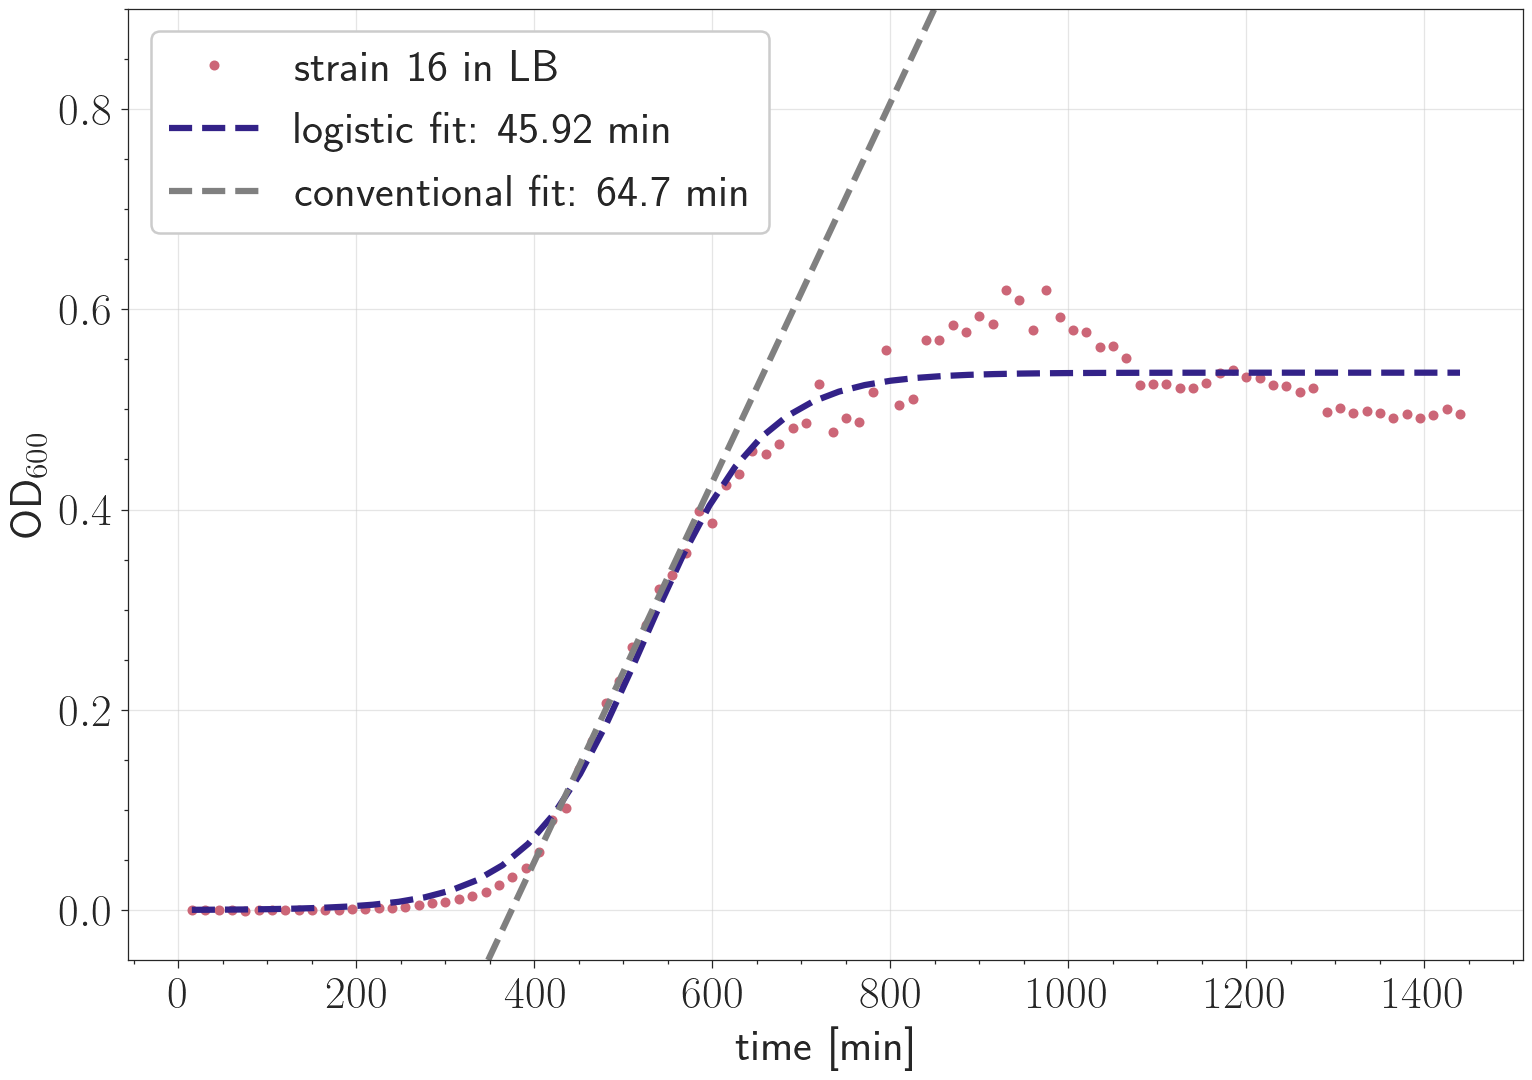

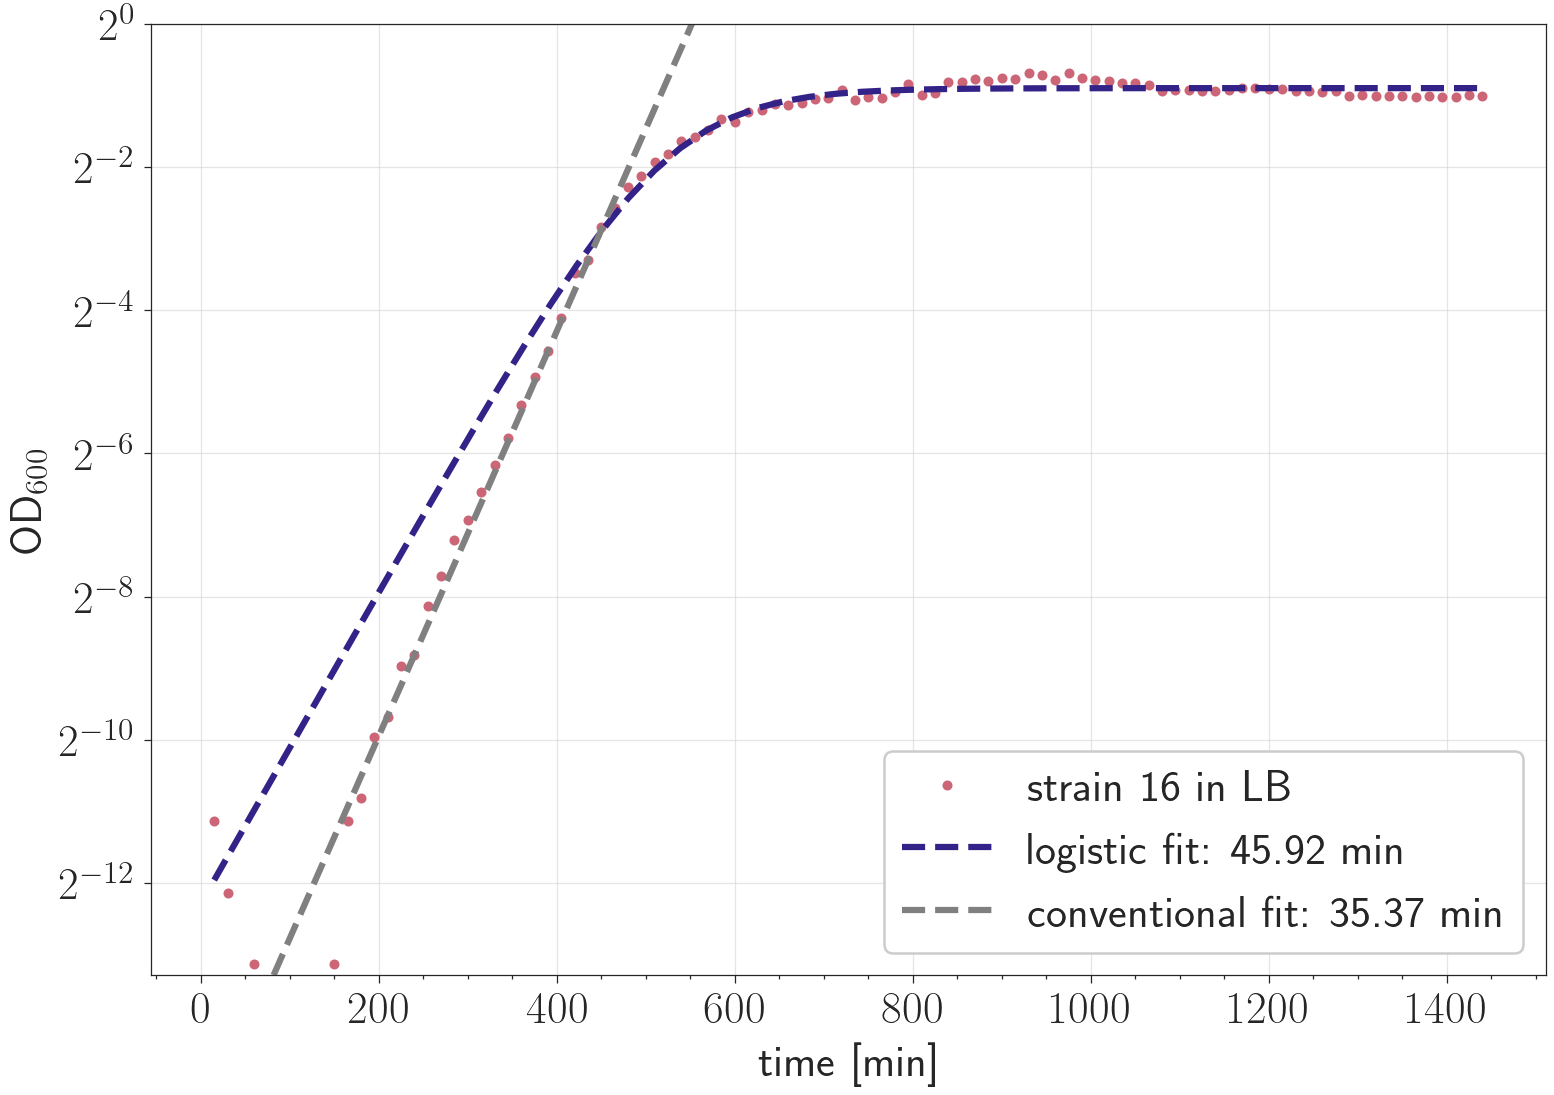

In [61]:
plt.close('all')
growth_sample = pd.read_csv('plate_reader_results/220615_Cstr16_LB_avg.csv')
plot_different_fits(growth_sample, 'linear', 405.0, 585.0, 'LB', 'strain 16 in LB')
plot_different_fits(growth_sample, 'log', 240.0, 390.0, 'LB', 'strain 16 in LB')

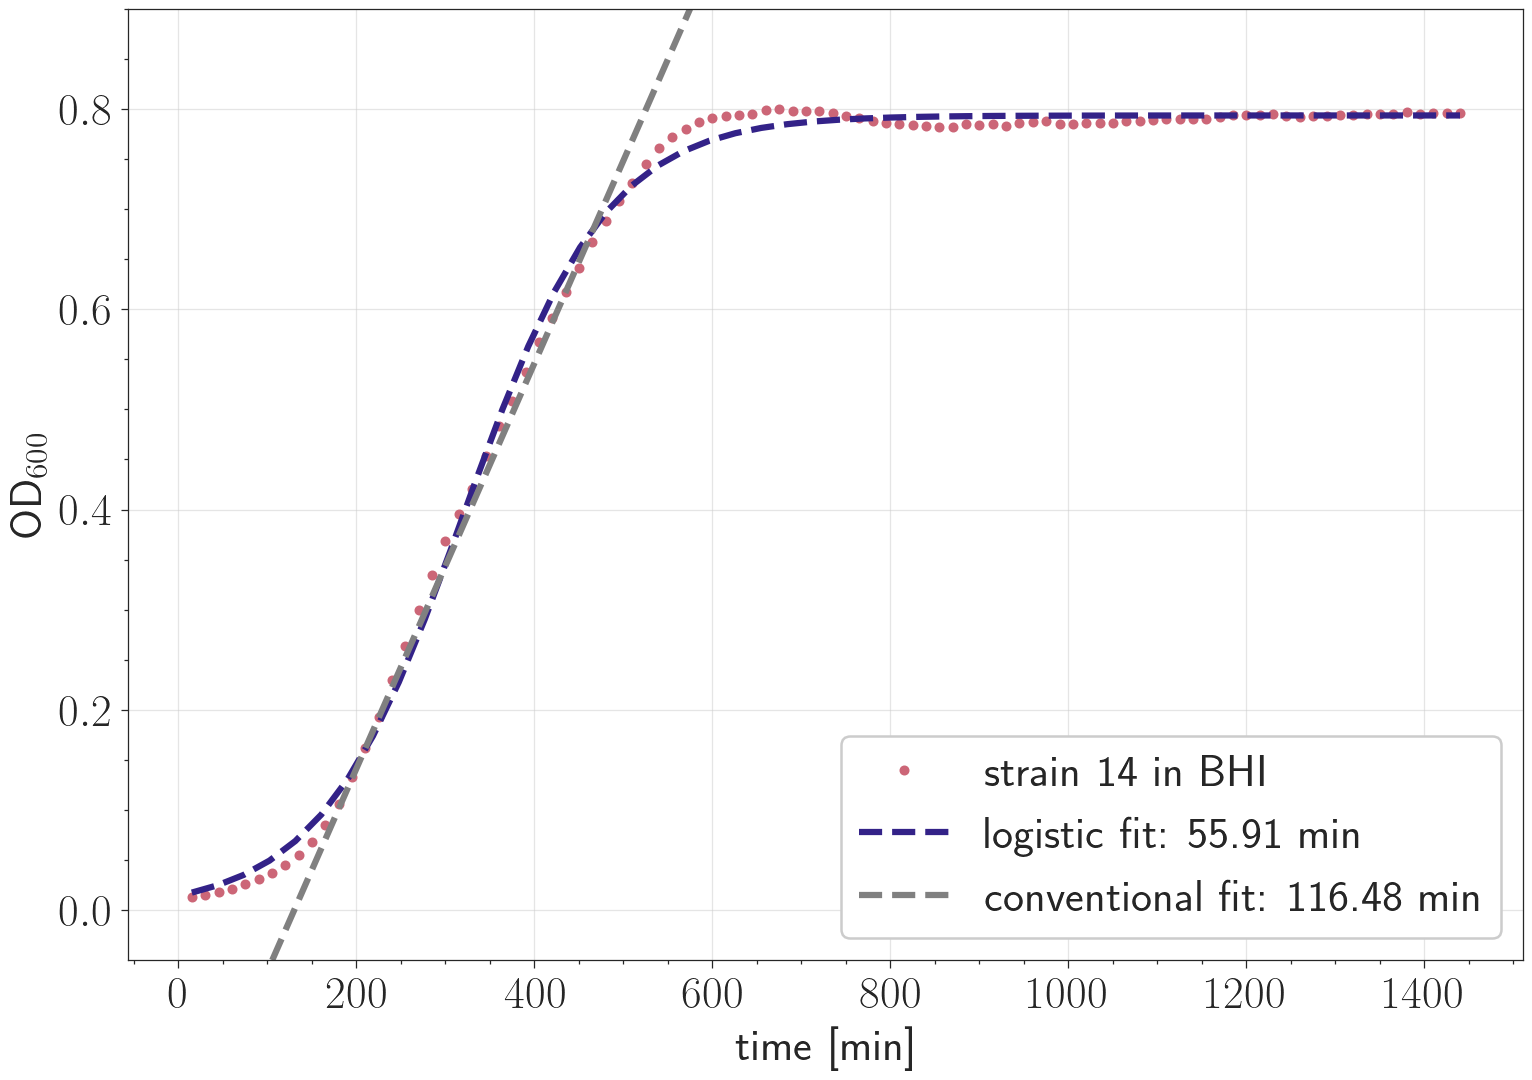

In [62]:
growth_sample = media_avg['BHI'][['Time', '14']]
plt.close('all')
plot_different_fits(growth_sample, 'linear', 210.0, 435.0, '14', 'strain 14 in BHI')
#plot_different_fits(growth_sample, 'log', 30.0, 210.0, '14', 'strain 14 in BHI')

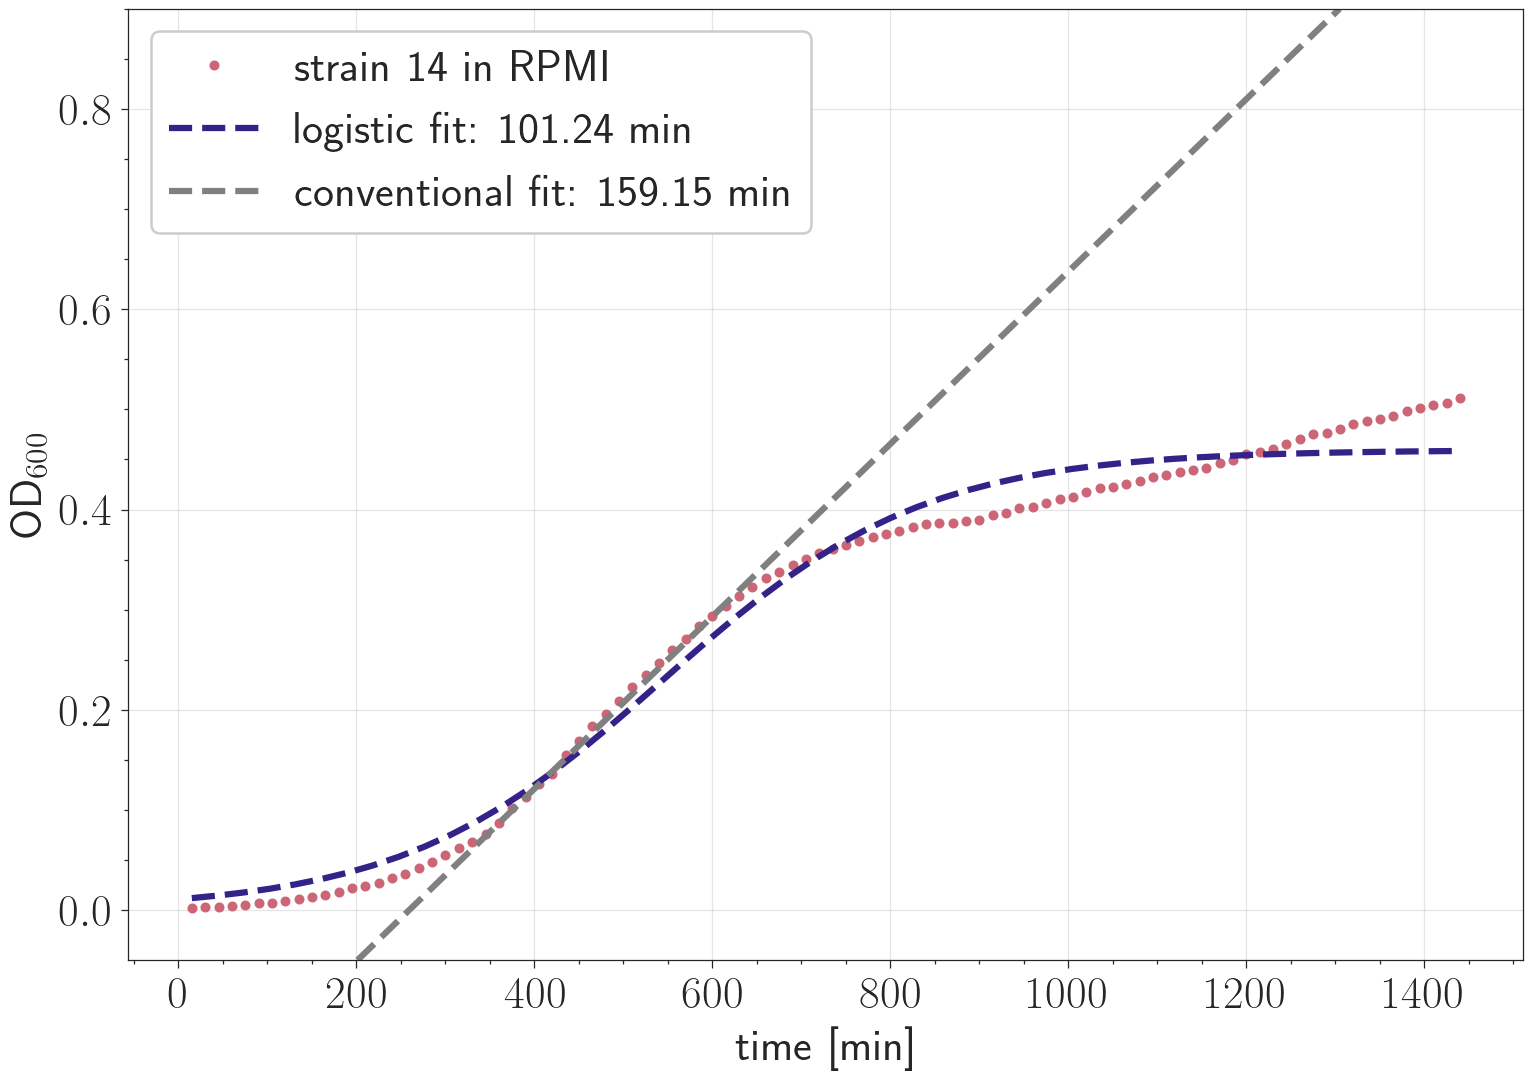

In [63]:
growth_sample = media_avg['RPMI'][['Time', '14']]
plt.close('all')
plot_different_fits(growth_sample, 'linear', 405.0, 600.0, '14', 'strain 14 in RPMI')
#plot_different_fits(growth_sample, 'log', 30.0, 390.0, '14', 'strain 14 in RPMI')

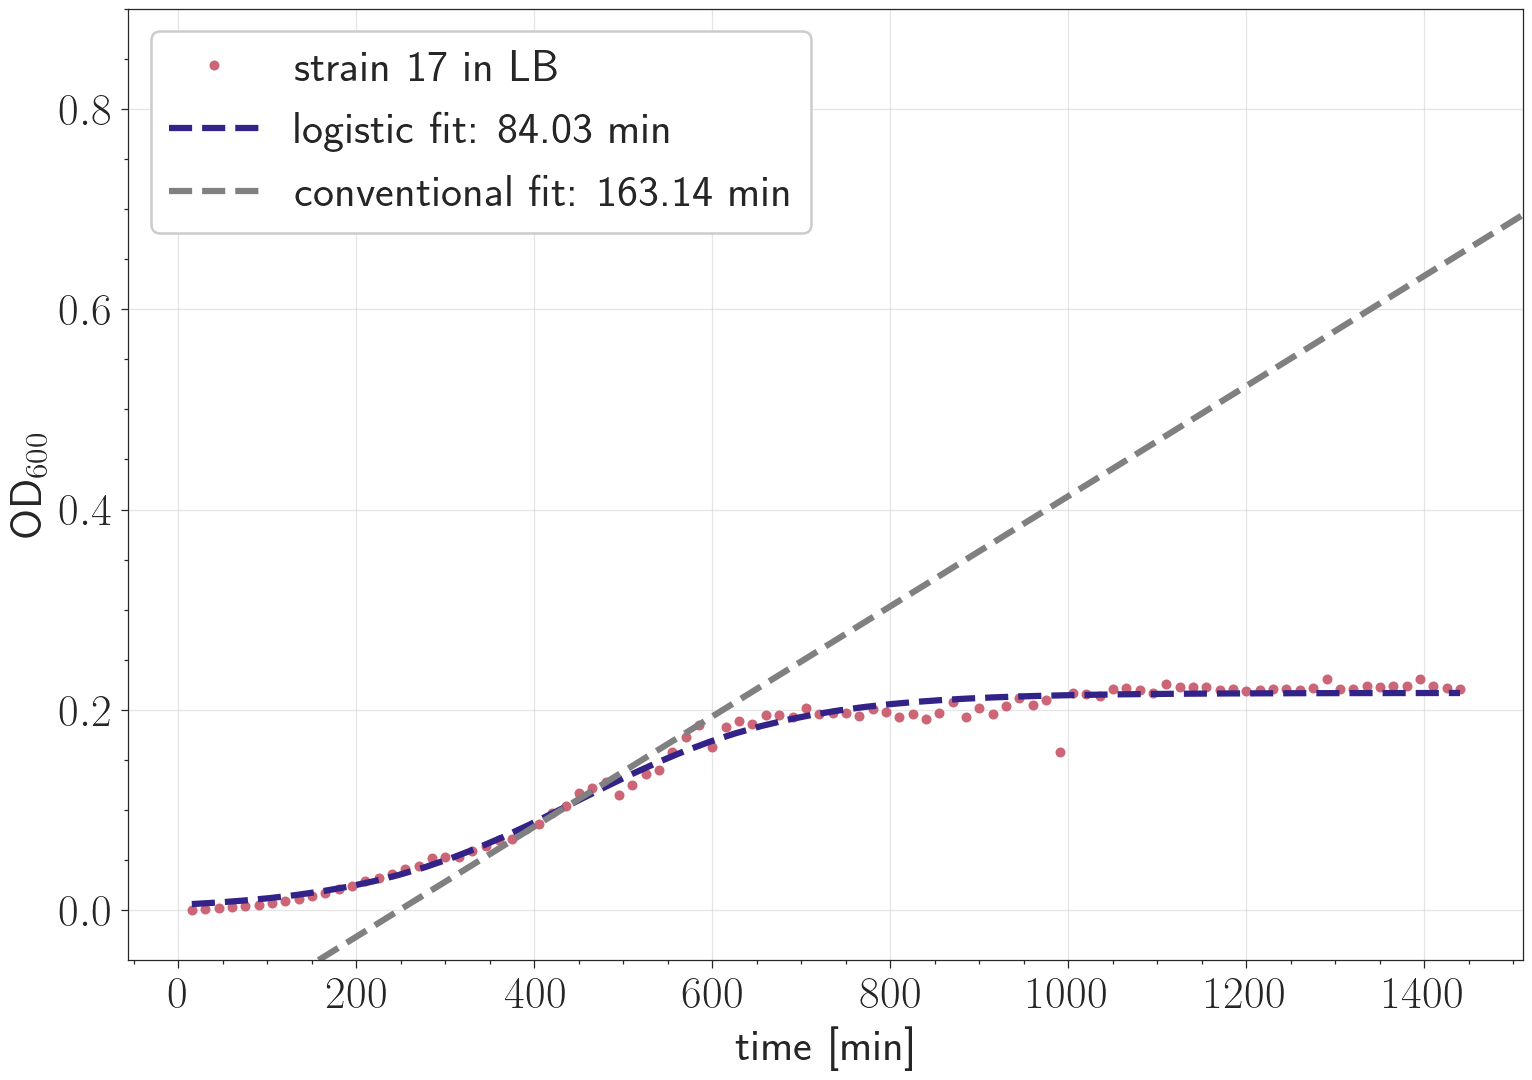

In [64]:
growth_sample = media_avg['LB'][['Time', '17']]
plt.close('all')
plot_different_fits(growth_sample, 'linear', 405.0, 585.0, '17', 'strain 17 in LB')
#plot_different_fits(growth_sample, 'log', 210.0, 390.0, '17', 'strain 17 in LB')

_Answers from Laura_

* __About growth rate:__ I don't think there's a real standard method in wet lab experiment. We usually use a way that highlights the best our results of interest. CFU concentrations is expressed in powers of ten and then usually showed on log-lin plots. However it's still possible to represent it on lin-lin plots if you expect small variations rather that log variations. OD measurements (like what you did) are rather plotted on lin-lin scales since OD is not expression in powers of ten. Since you estimate your growth rates from OD measurements, I guess you should rather use lin-lin scales. But in theory, the log transformation should not impact too much the conclusions you draw from your curves, no? (Value will be different but not your trends between your conditions ?).

* __About errors bars:__ Growth rate is indeed often used in articles without any real quantification; people tend to use this word to qualify the overall grow or aspect of a growth curve. I've not seen your results yet but I think you should keep these growth rates with error bars. It's more accurate and the variability of your results should not be neglected.


## Fitting with lmfit instead of curve_fit

`lmfit` also uses a least-squares approach to fit the data, it includes automatic error calculation.

In [65]:
from lmfit import Model, Parameter, fit_report
import lmfit

We define functions to fit the data that use the `Model` object from lmfit.

In [66]:
def fit_logistic(growth_sample, column):
    model = Model(logistic, independent_vars=['t'])
    return model.fit(growth_sample[column], t=growth_sample['Time'],
          K=Parameter('K', value=0.2),
          N0=Parameter('N0', value=0.005),
          r=Parameter('r', value=0.05),
          )
    
def fit_gompertz(growth_sample, column):
    model = Model(gompertz, independent_vars=['t'])
    return model.fit(growth_sample[column], t=growth_sample['Time'],
          K=Parameter('K', value=0.8),
          lag=Parameter('lag', value=1),
          r=Parameter('r', value=0.01),
          )

In [67]:
def plot_result(growth_sample, fit_result, title=growth_sample.columns[1]):
    dely = fit_result.eval_uncertainty(sigma=3)
    growth_sample.rename({growth_sample.columns[1]:'data'}, 
                         axis=1).plot(x='Time',
                       style='o',
                       grid=True,
                       ylabel='OD$_{600}$',
                       xlabel='time [min]',
                       figsize=(12,9),
                       )
    plt.yscale('log', basey=2)
    plt.plot(growth_sample['Time'], fit_result.best_fit, label='best fit')
    plt.fill_between(growth_sample['Time'], fit_result.best_fit-dely, fit_result.best_fit+dely, 
                 color="#ABABAB",
                 label='3-$\sigma$ uncertainty band')
    plt.title(title)
    plt.legend()
    
def determine_td(fit_result):
    fit_res = pd.DataFrame([(p.name, p.value, p.stderr) for p in fit_result.params.values()], 
            columns=('name', 'r_fitted', 'r_stderr'))
    growth = fit_res[fit_res['name'] == 'r'].drop('name', axis=1)
    growth['td'] = np.log(2)/growth['r_fitted']
    growth['td_plus_err'] = np.log(2)/(growth['r_fitted'] + growth['r_stderr'])
    growth['td_min_err'] = np.log(2)/(growth['r_fitted'] - growth['r_stderr'])
    growth['td_err'] = growth['td_min_err'] - growth['td_plus_err']
    return growth

,r_fitted,r_stderr,td,td_plus_err,td_min_err,td_err
2,0.008249,0.000308,84.03289,81.005682,87.295137,6.289455


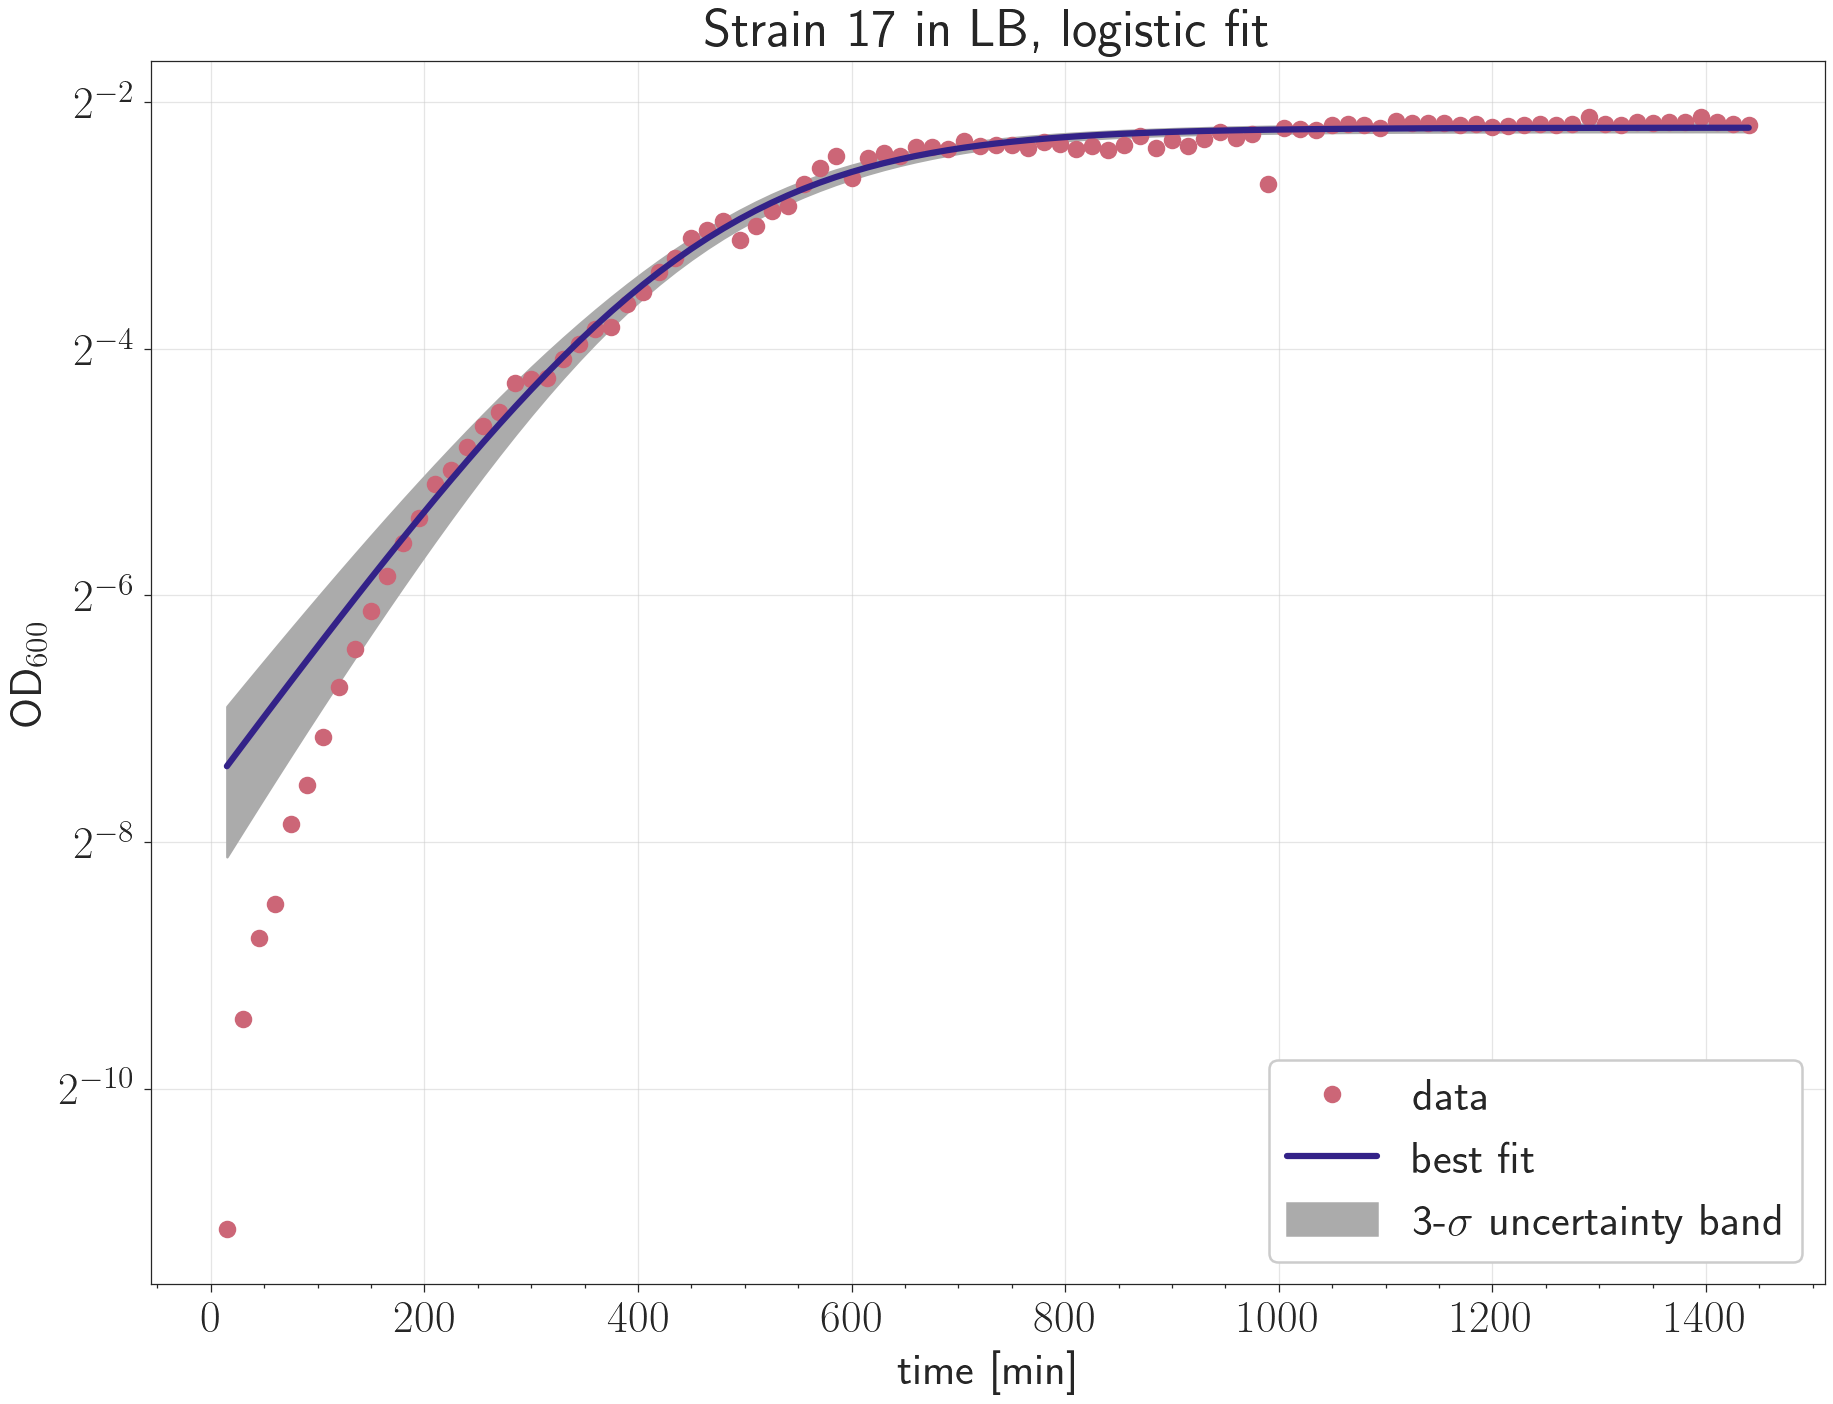

In [68]:
growth_sample =  media_avg['LB'][['Time', '17']]
res = fit_logistic(growth_sample, '17')
plot_result(growth_sample, res, 'Strain 17 in LB, logistic fit')
determine_td(res)

,r_fitted,r_stderr,td,td_plus_err,td_min_err,td_err
2,0.005241,0.000204,132.242912,127.297304,137.588336,10.291032


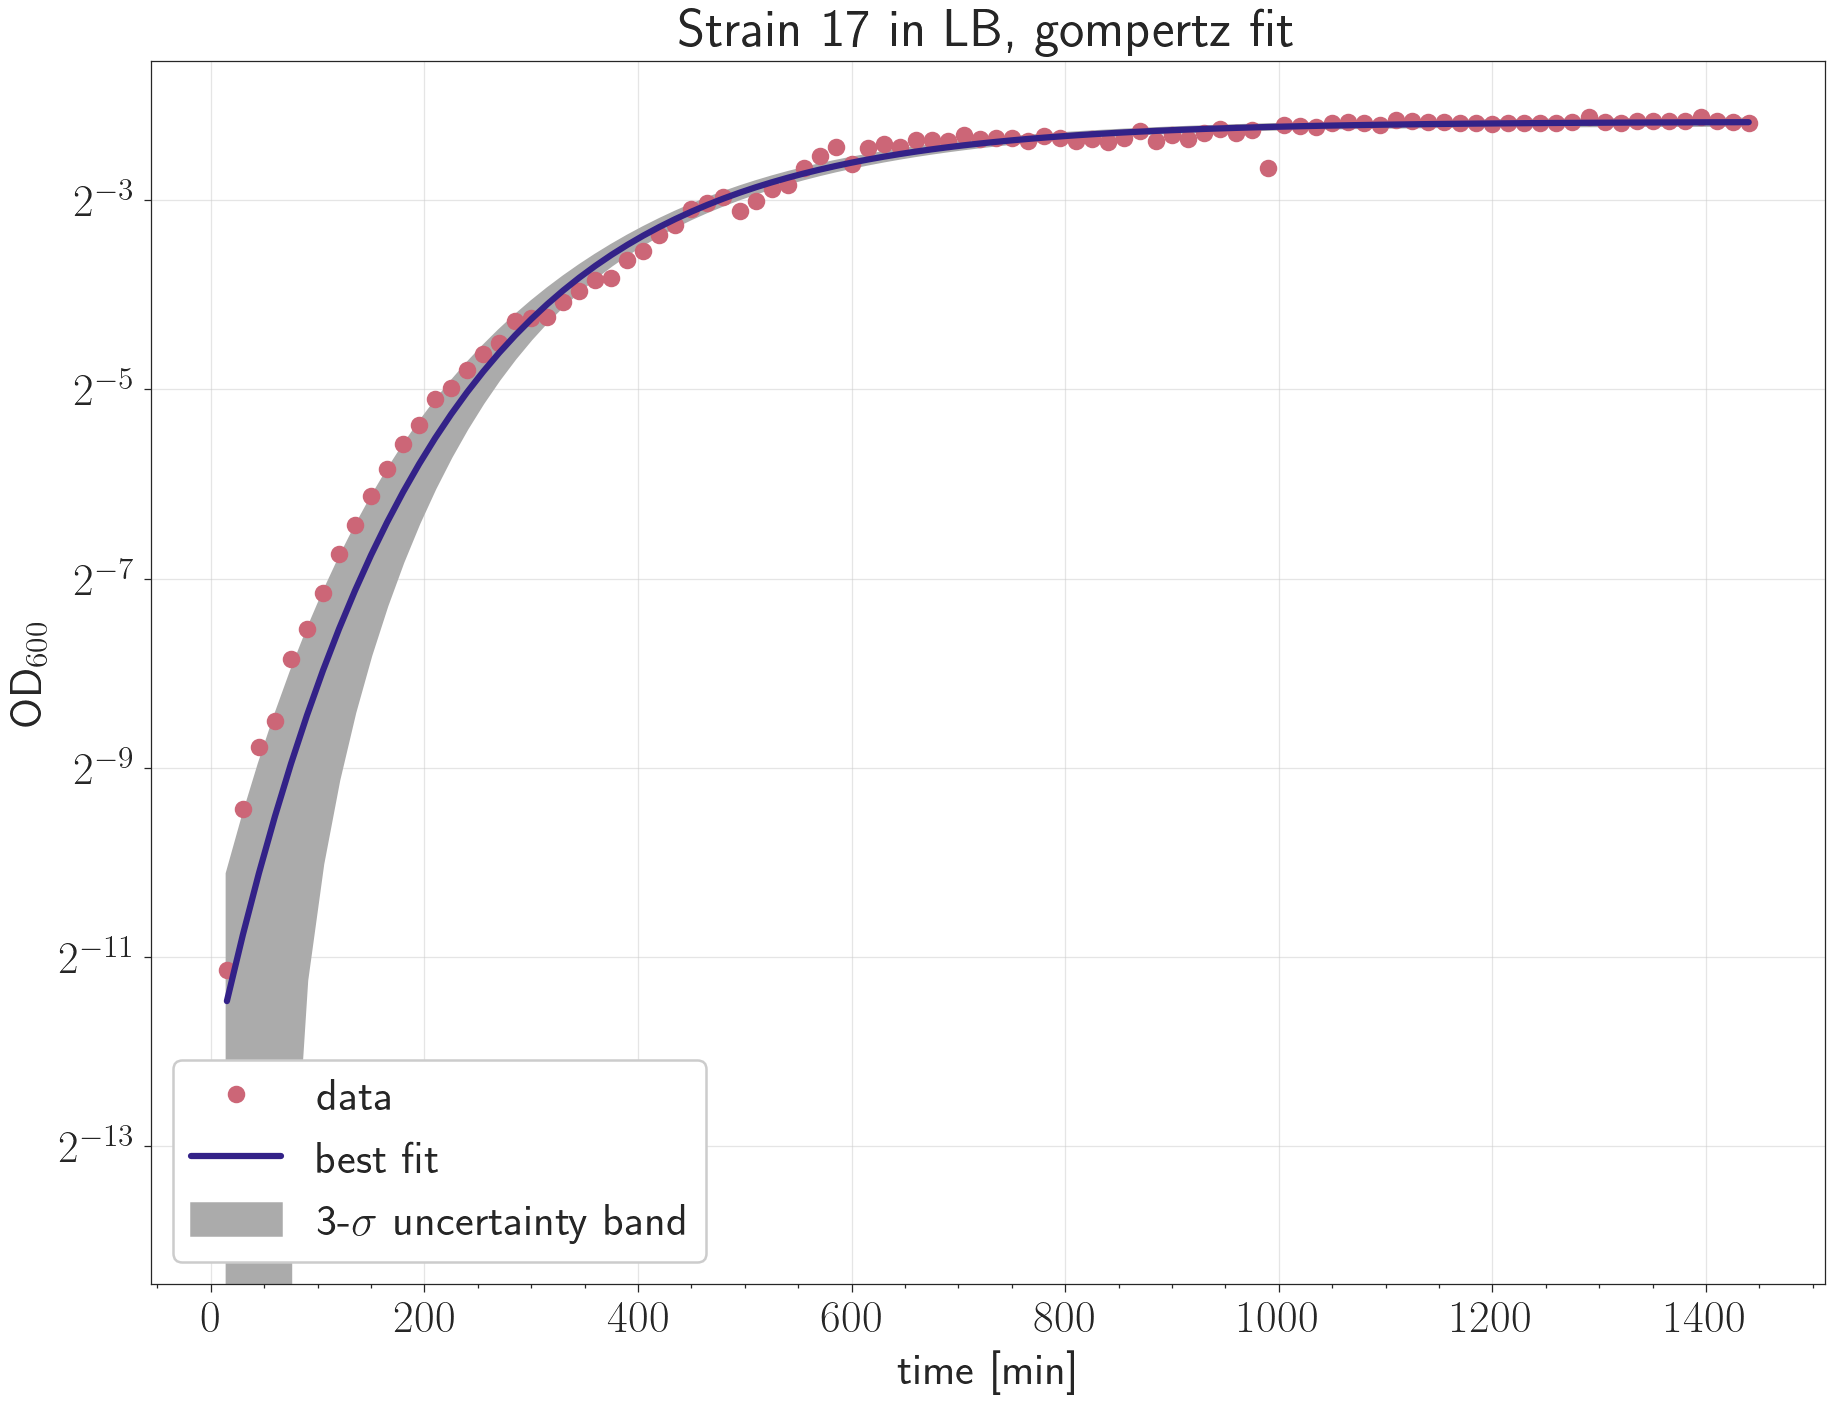

In [69]:
res = fit_gompertz(growth_sample, '17')
plot_result(growth_sample, res, 'Strain 17 in LB, gompertz fit')
determine_td(res)

,2
r_fitted,0.012398
r_stderr,0.000181
td,55.905924
td_plus_err,55.101881
td_min_err,56.733780
td_err,1.631900


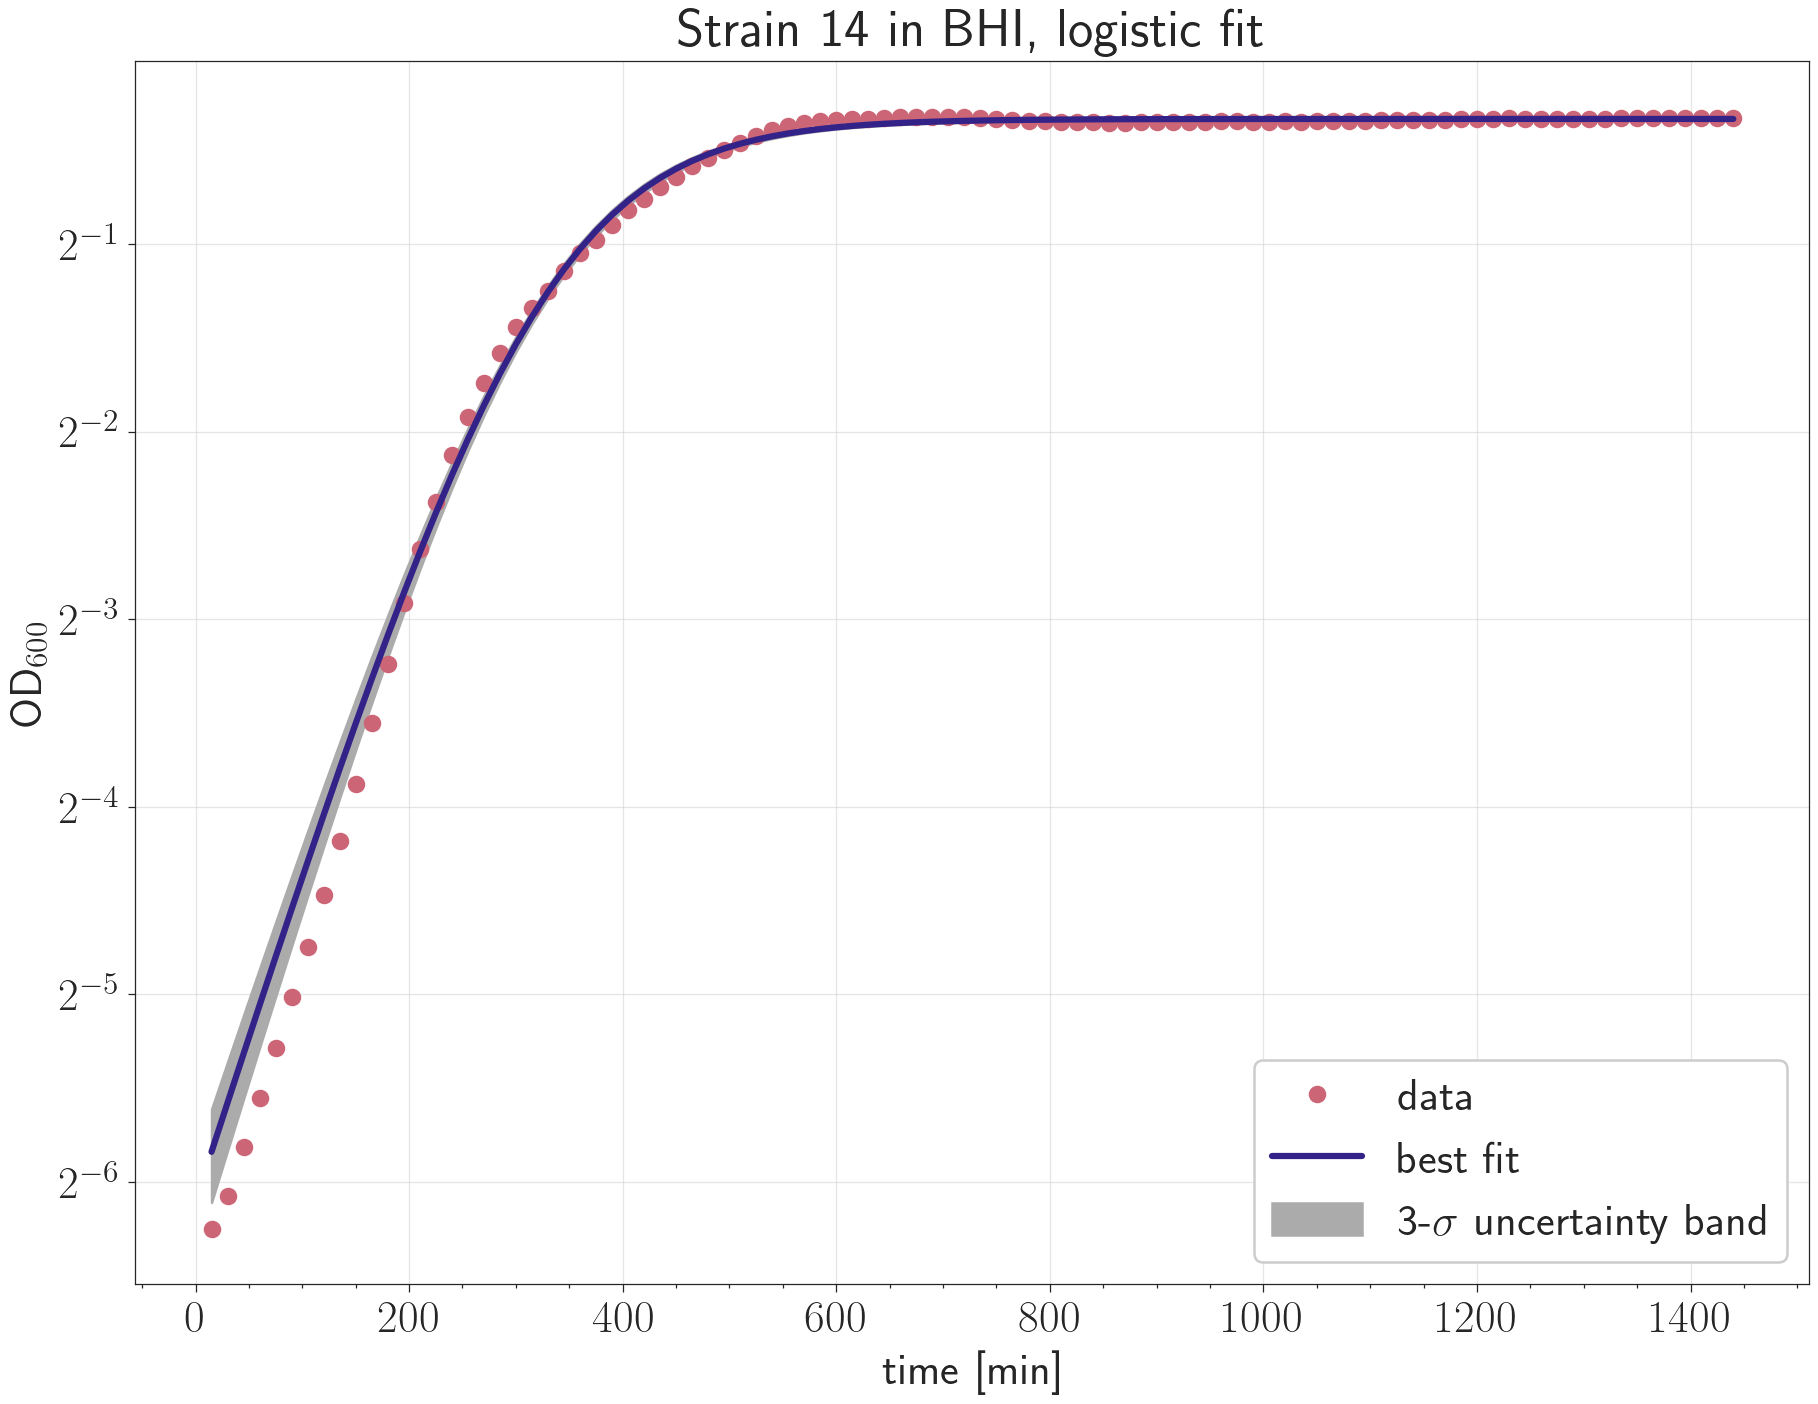

In [70]:
growth_sample =  media_avg['BHI'][['Time', '14']]
res = fit_logistic(growth_sample, '14')
plot_result(growth_sample, res, 'Strain 14 in BHI, logistic fit')
determine_td(res).T

,2
r_fitted,0.008604
r_stderr,0.000179
td,80.561569
td_plus_err,78.922244
td_min_err,82.270440
td_err,3.348196


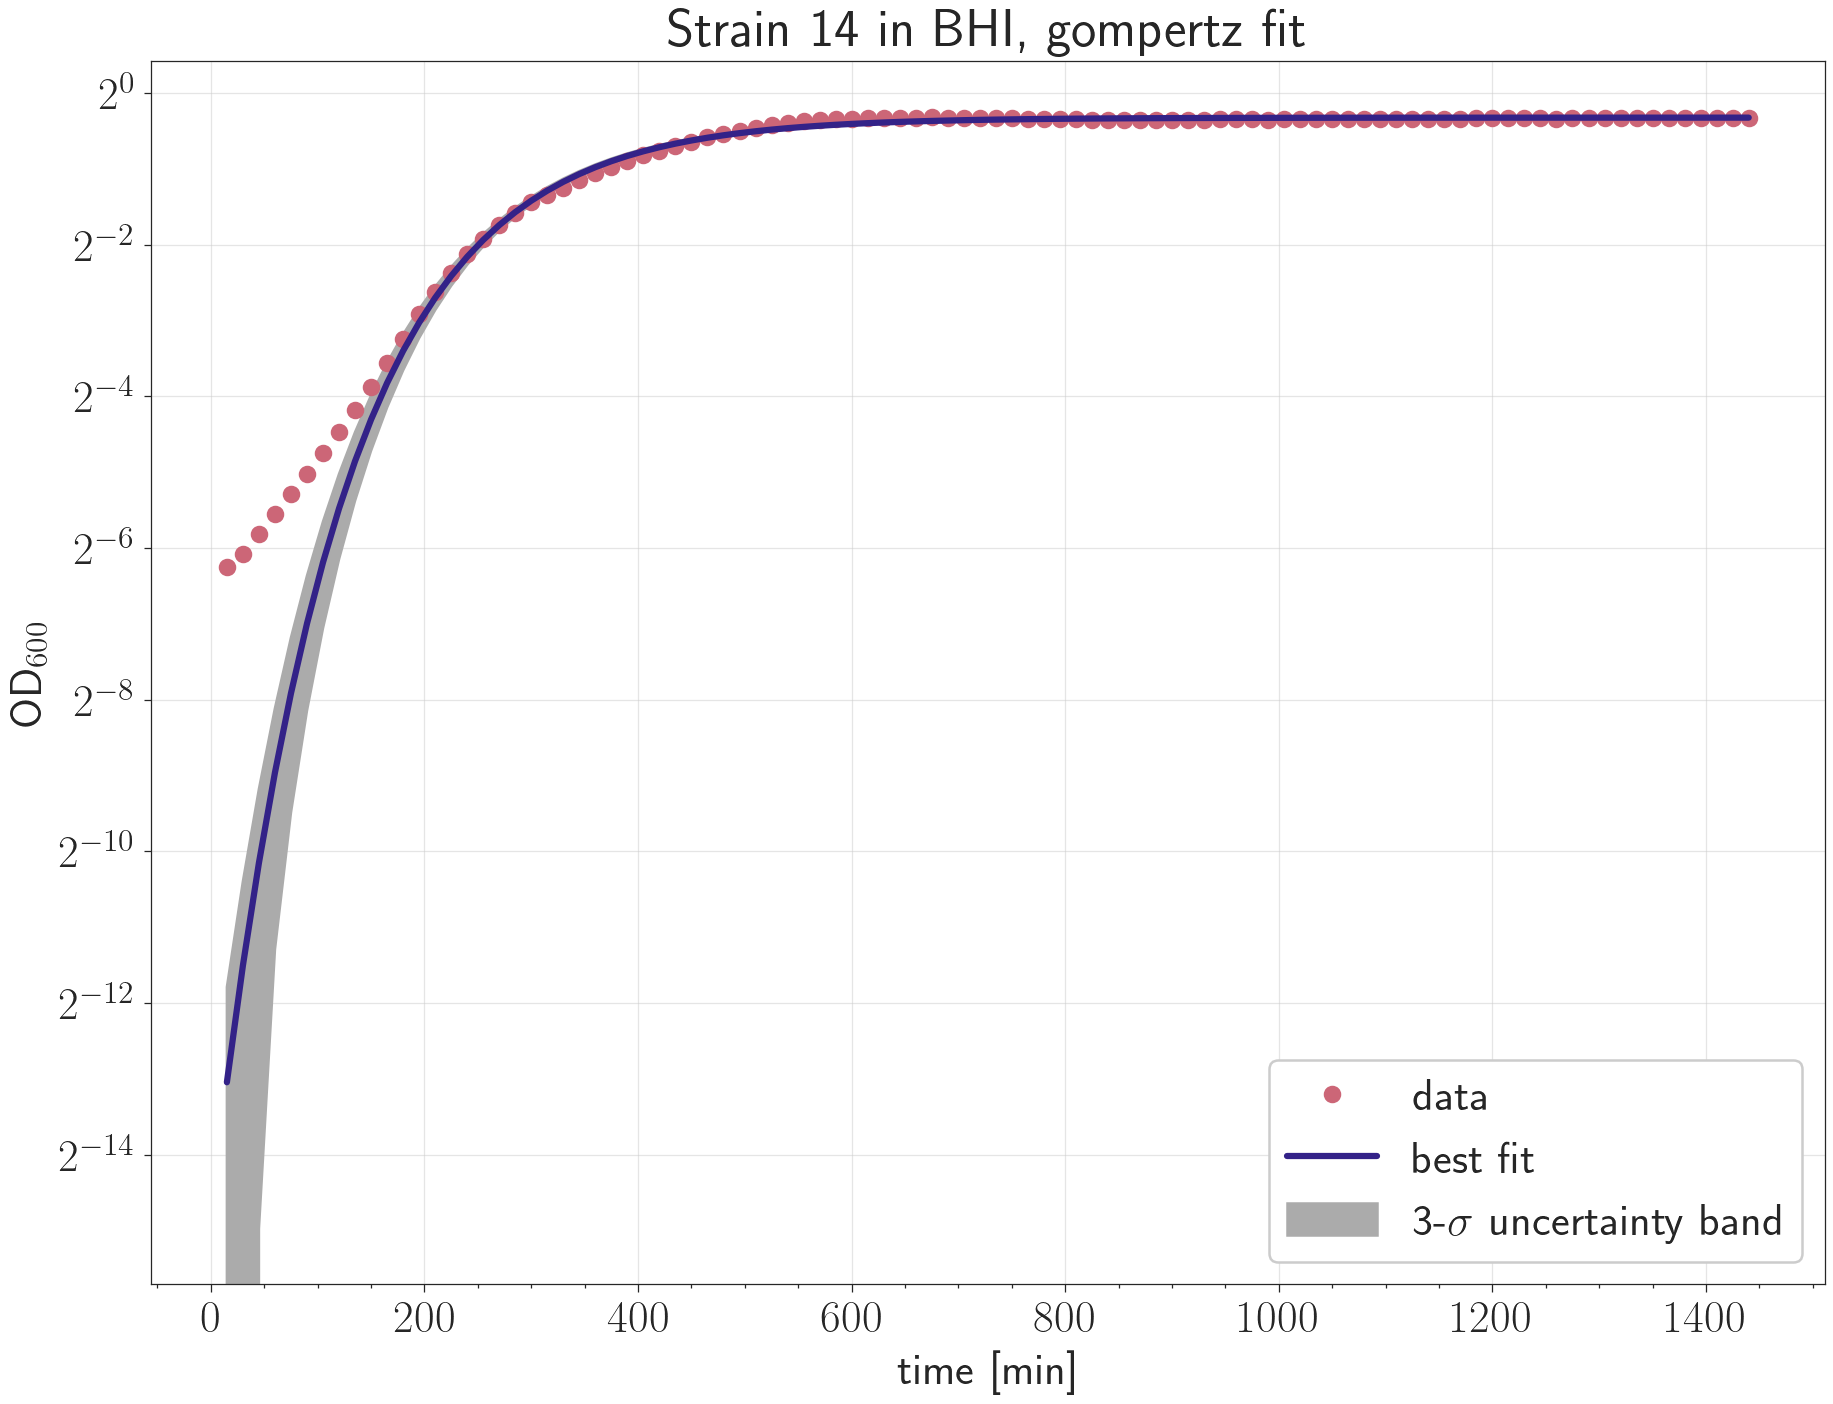

In [71]:
res = fit_gompertz(growth_sample, '14')
plot_result(growth_sample, res, 'Strain 14 in BHI, gompertz fit')
determine_td(res).T

,r_fitted,r_stderr,td,td_plus_err,td_min_err,td_err
2,0.006846,0.000268,101.241167,97.420959,105.373209,7.95225


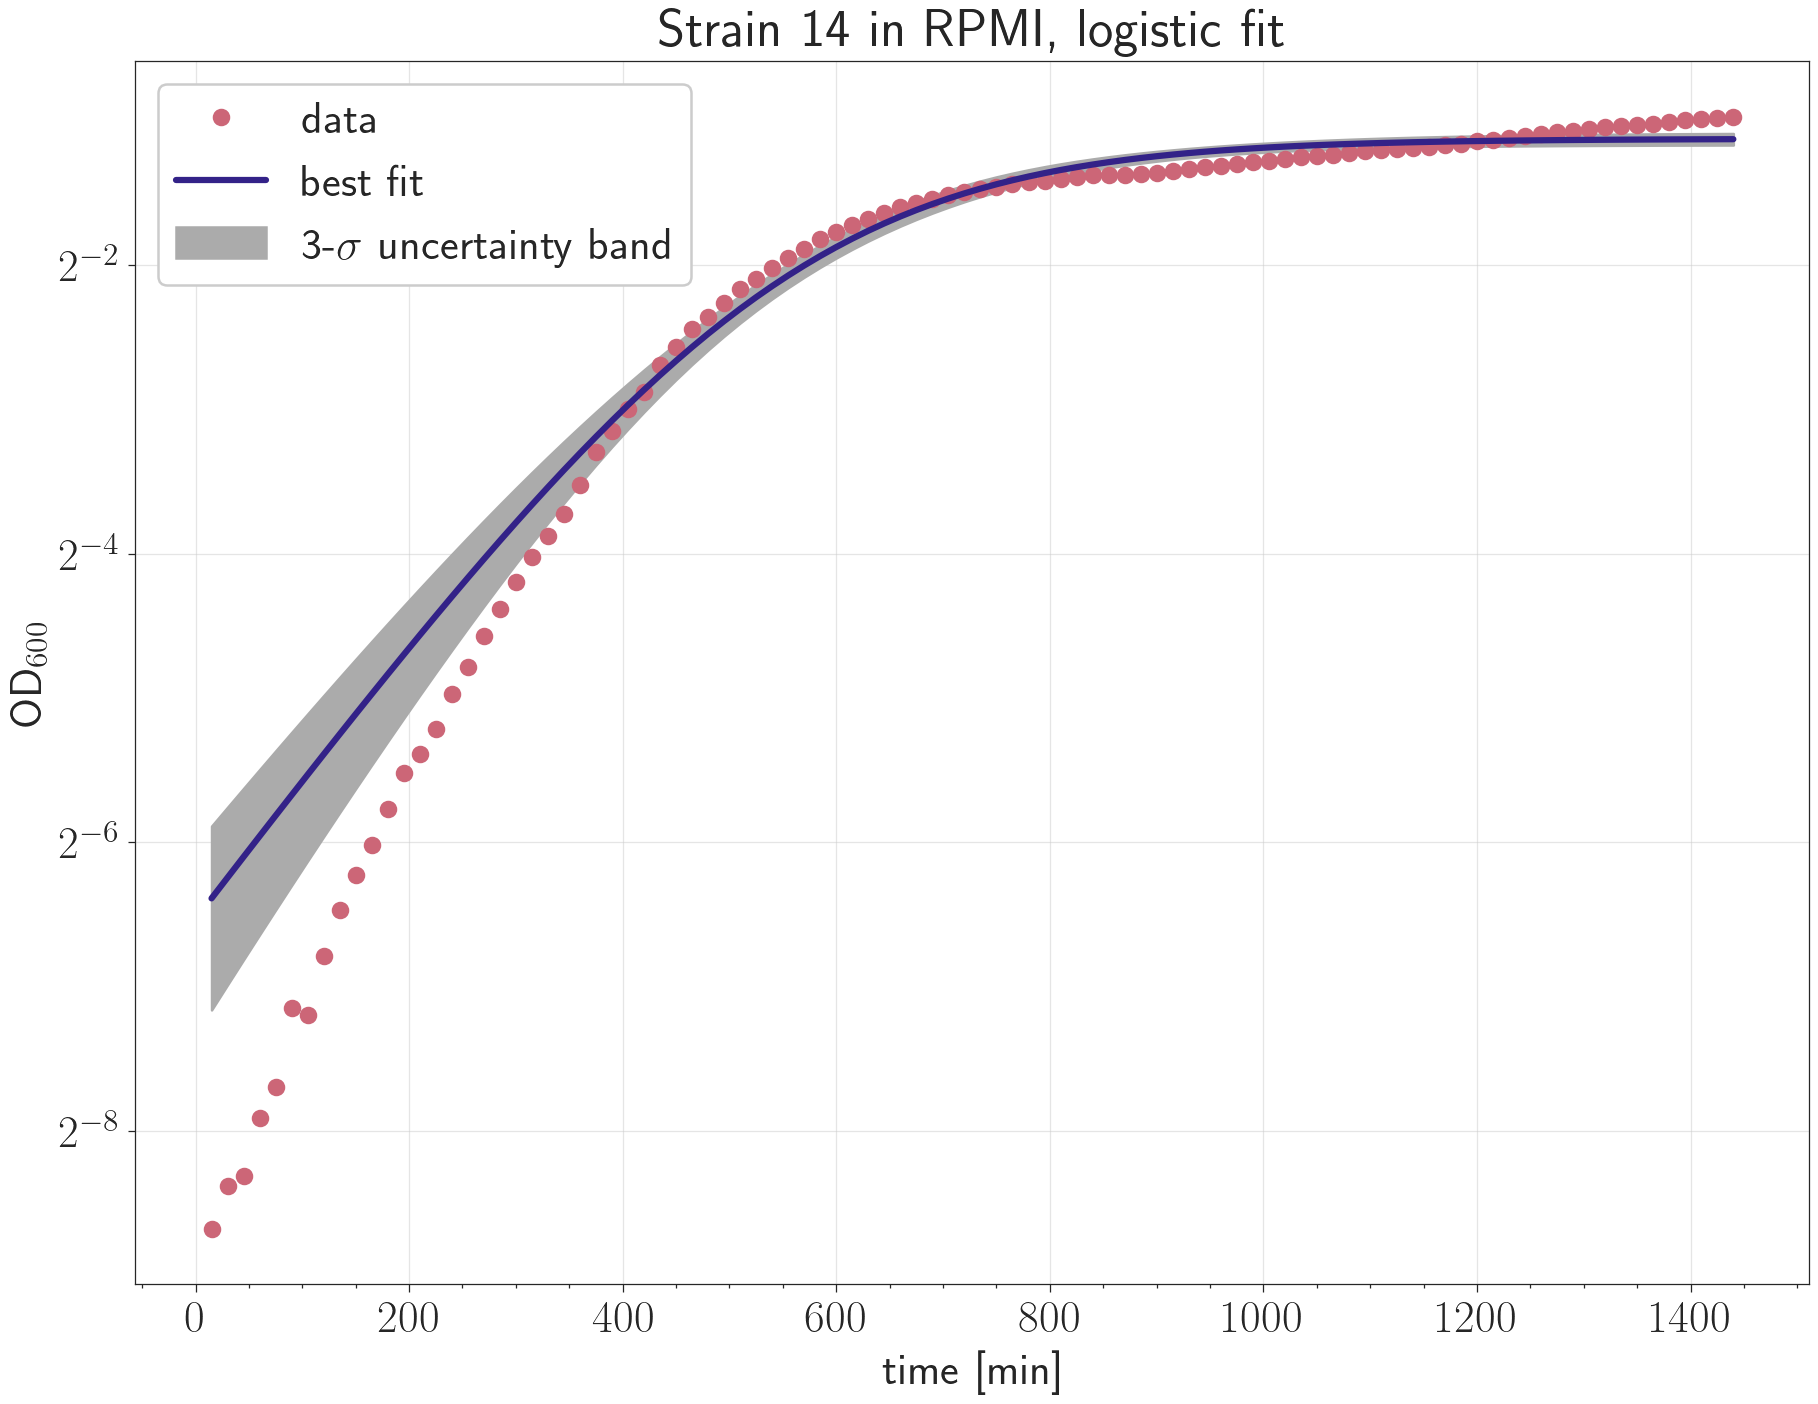

In [72]:
growth_sample =  media_avg['RPMI'][['Time', '14']]
res = fit_logistic(growth_sample, '14')
plot_result(growth_sample, res, 'Strain 14 in RPMI, logistic fit')
determine_td(res)

,r_fitted,r_stderr,td,td_plus_err,td_min_err,td_err
2,0.015096,0.000866,45.9154,43.424356,48.709634,5.285278


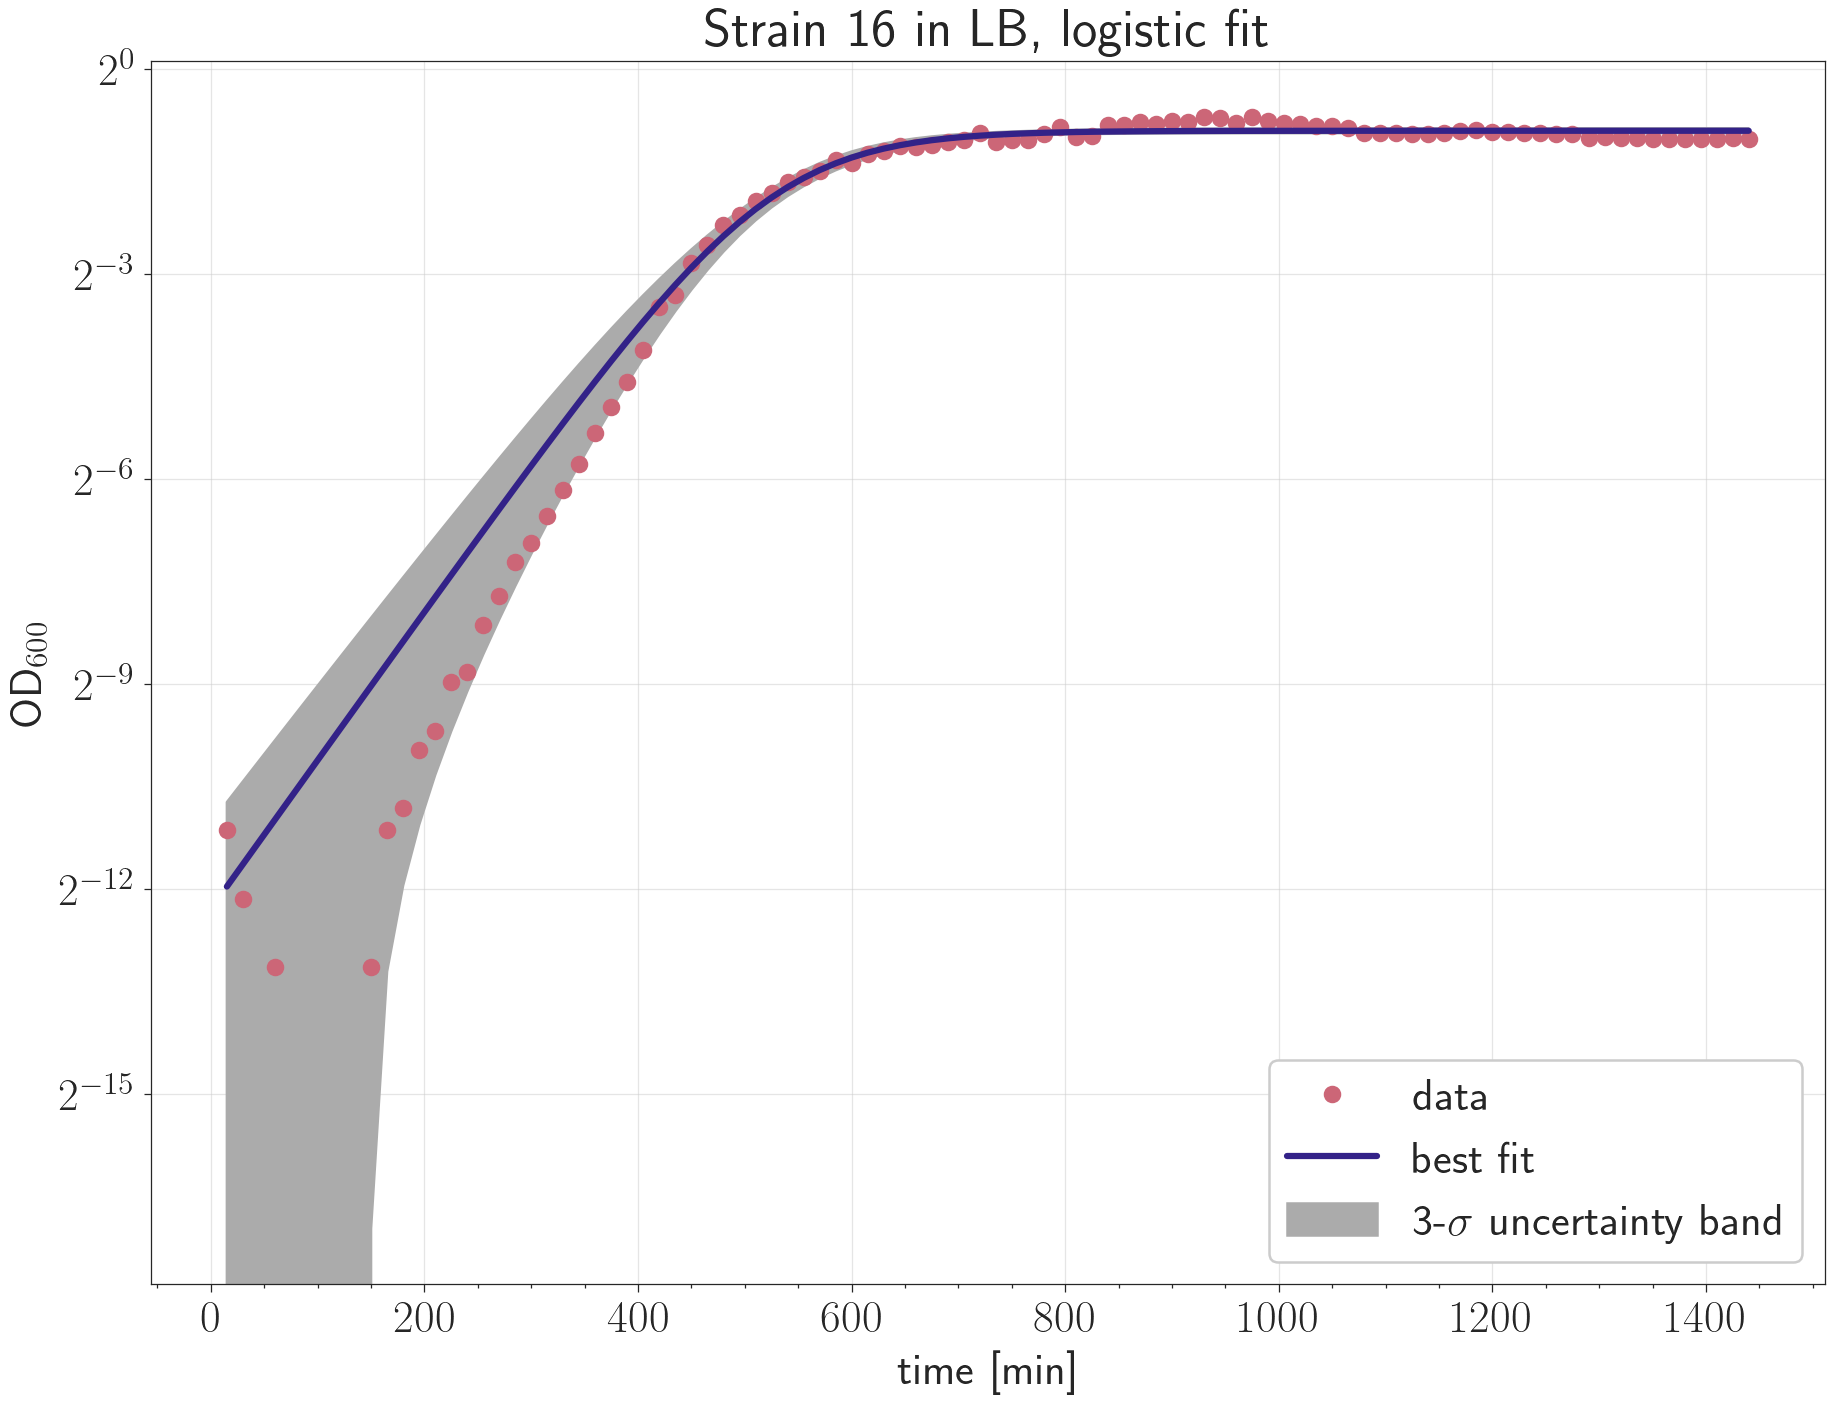

In [73]:
growth_sample = pd.read_csv('plate_reader_results/220615_Cstr16_LB_avg.csv')
res = fit_logistic(growth_sample, 'LB')
plot_result(growth_sample, res, 'Strain 16 in LB, logistic fit')
determine_td(res)

,r_fitted,r_stderr,td,td_plus_err,td_min_err,td_err
2,0.010654,0.000613,65.062706,61.520363,69.03791,7.517547


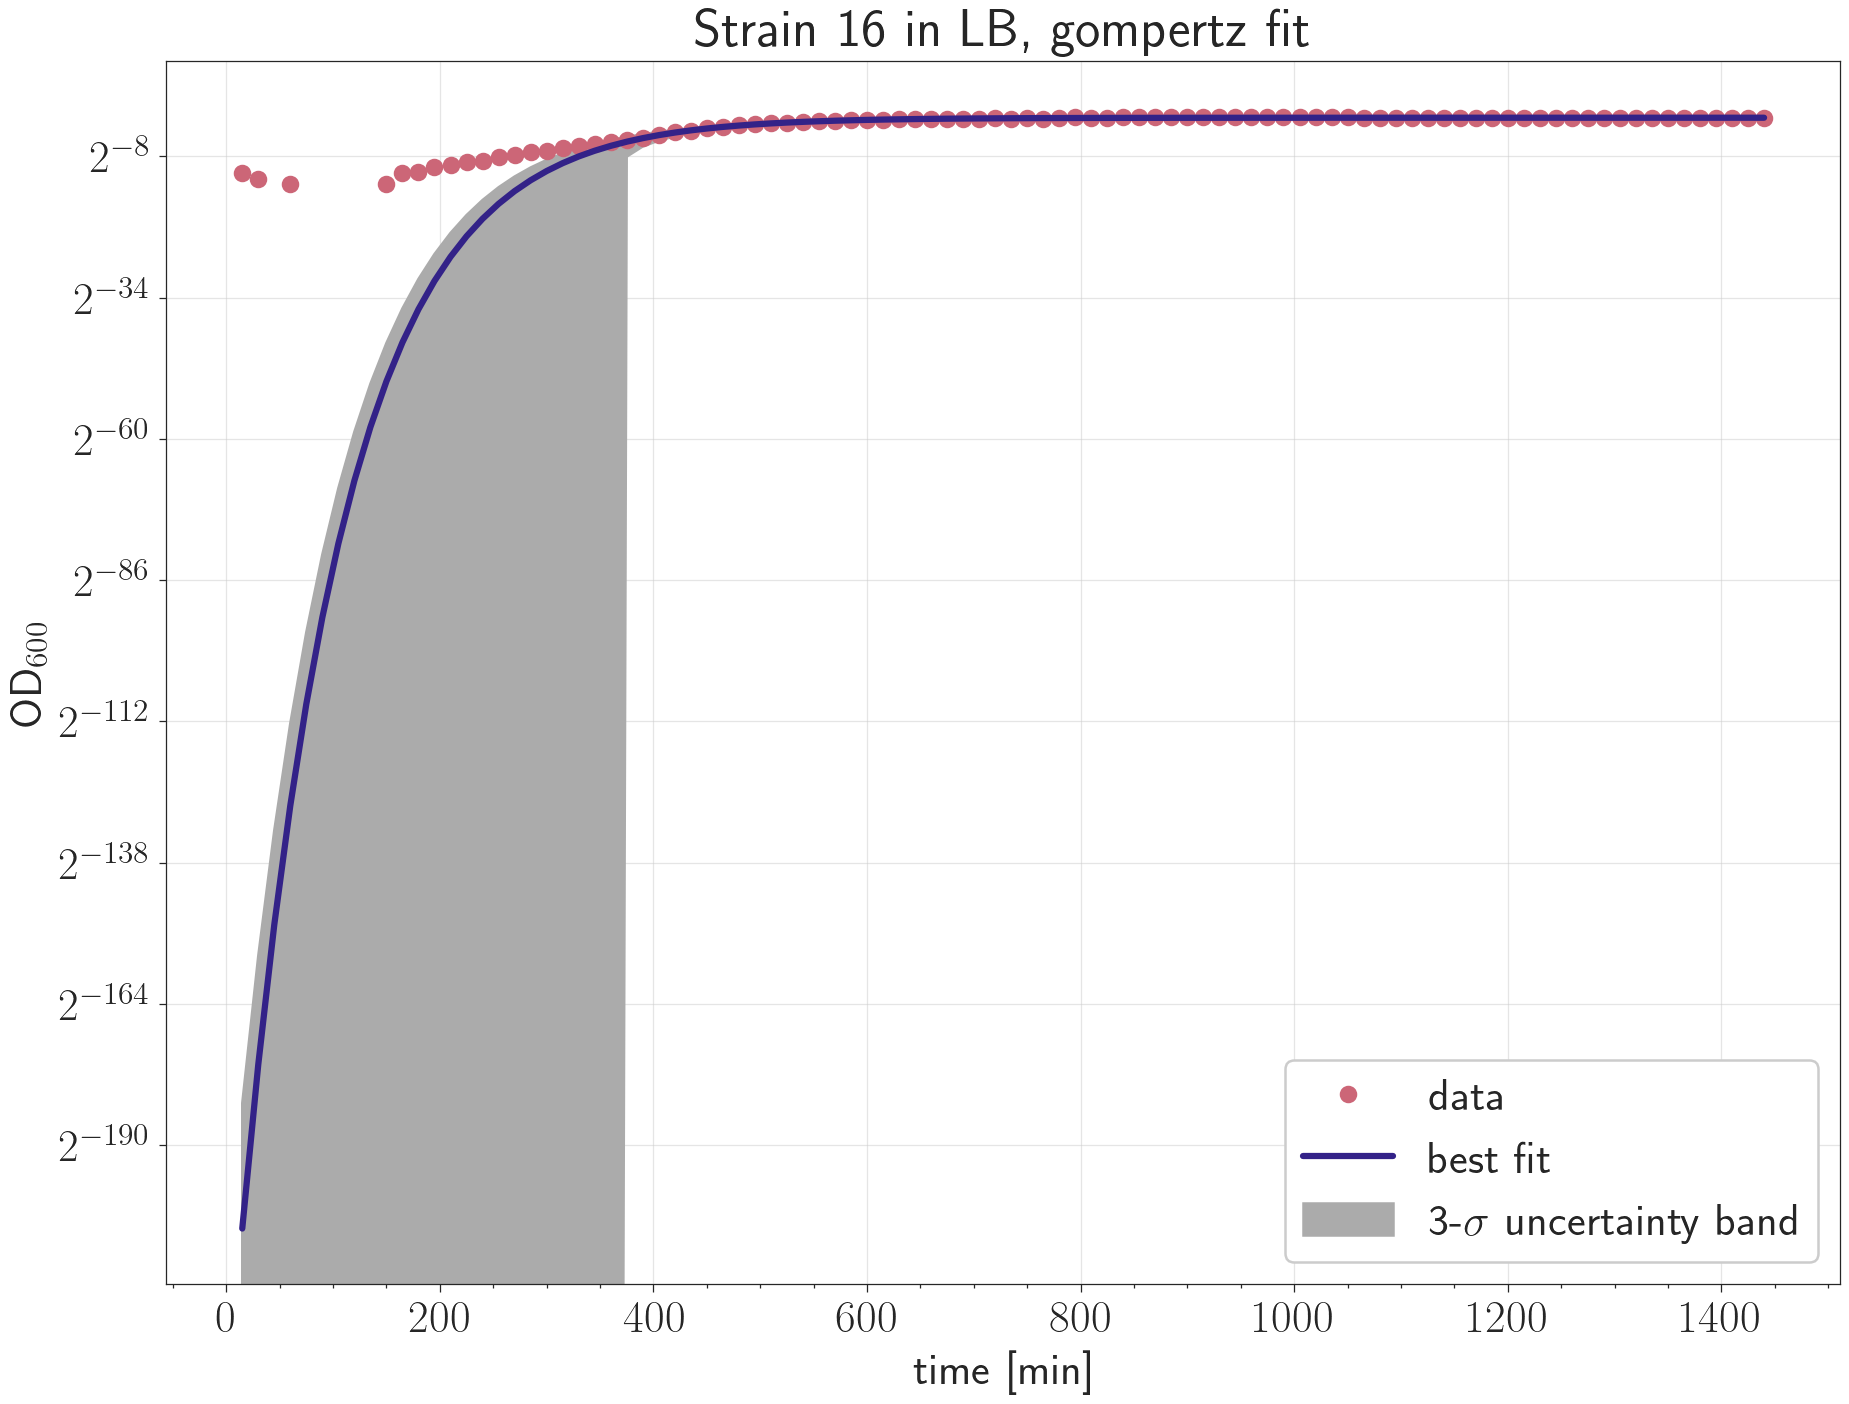

In [74]:
res = fit_gompertz(growth_sample, 'LB')
plot_result(growth_sample, res, 'Strain 16 in LB, gompertz fit')
determine_td(res)

## Fitting with curveball

["Curveball is an open-source software for analysis and visualization of high-throughput growth curve data and prediction of competition experiment results."](https://curveball.yoavram.com/)

In [75]:
import curveball

,r_fitted,r_stderr,td,td_plus_err,td_min_err,td_err
2,0.017153,None,40.409643,NaN,NaN,NaN


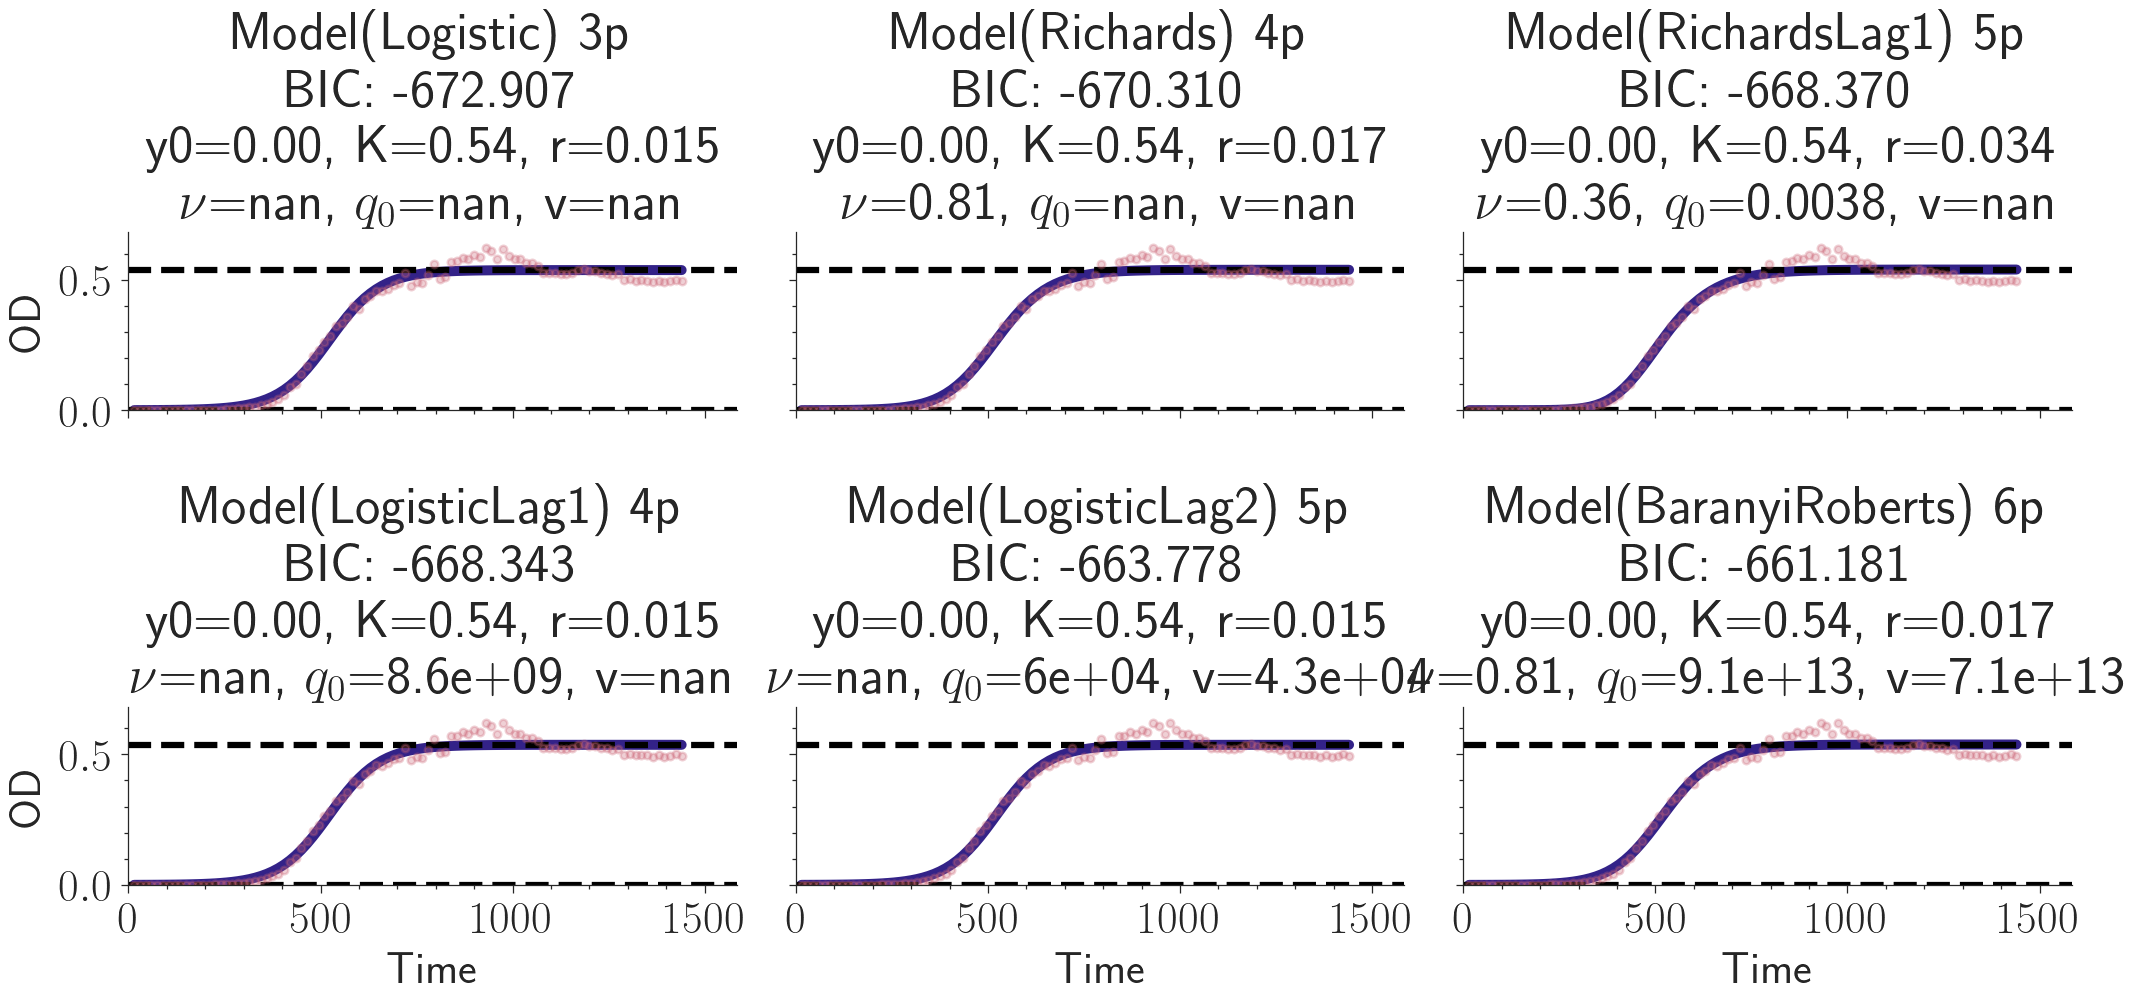

In [76]:
growth_data = pd.read_csv('plate_reader_results/220615_Cstr16_LB_avg.csv')
res, fig, ax = curveball.models.fit_model(growth_data.rename({'LB':'OD'},axis=1),PLOT=True,PRINT=False)
determine_td(res[5])

,r_fitted,r_stderr,td,td_plus_err,td_min_err,td_err
2,0.006847,0.000268,101.240401,97.420059,105.372604,7.952545


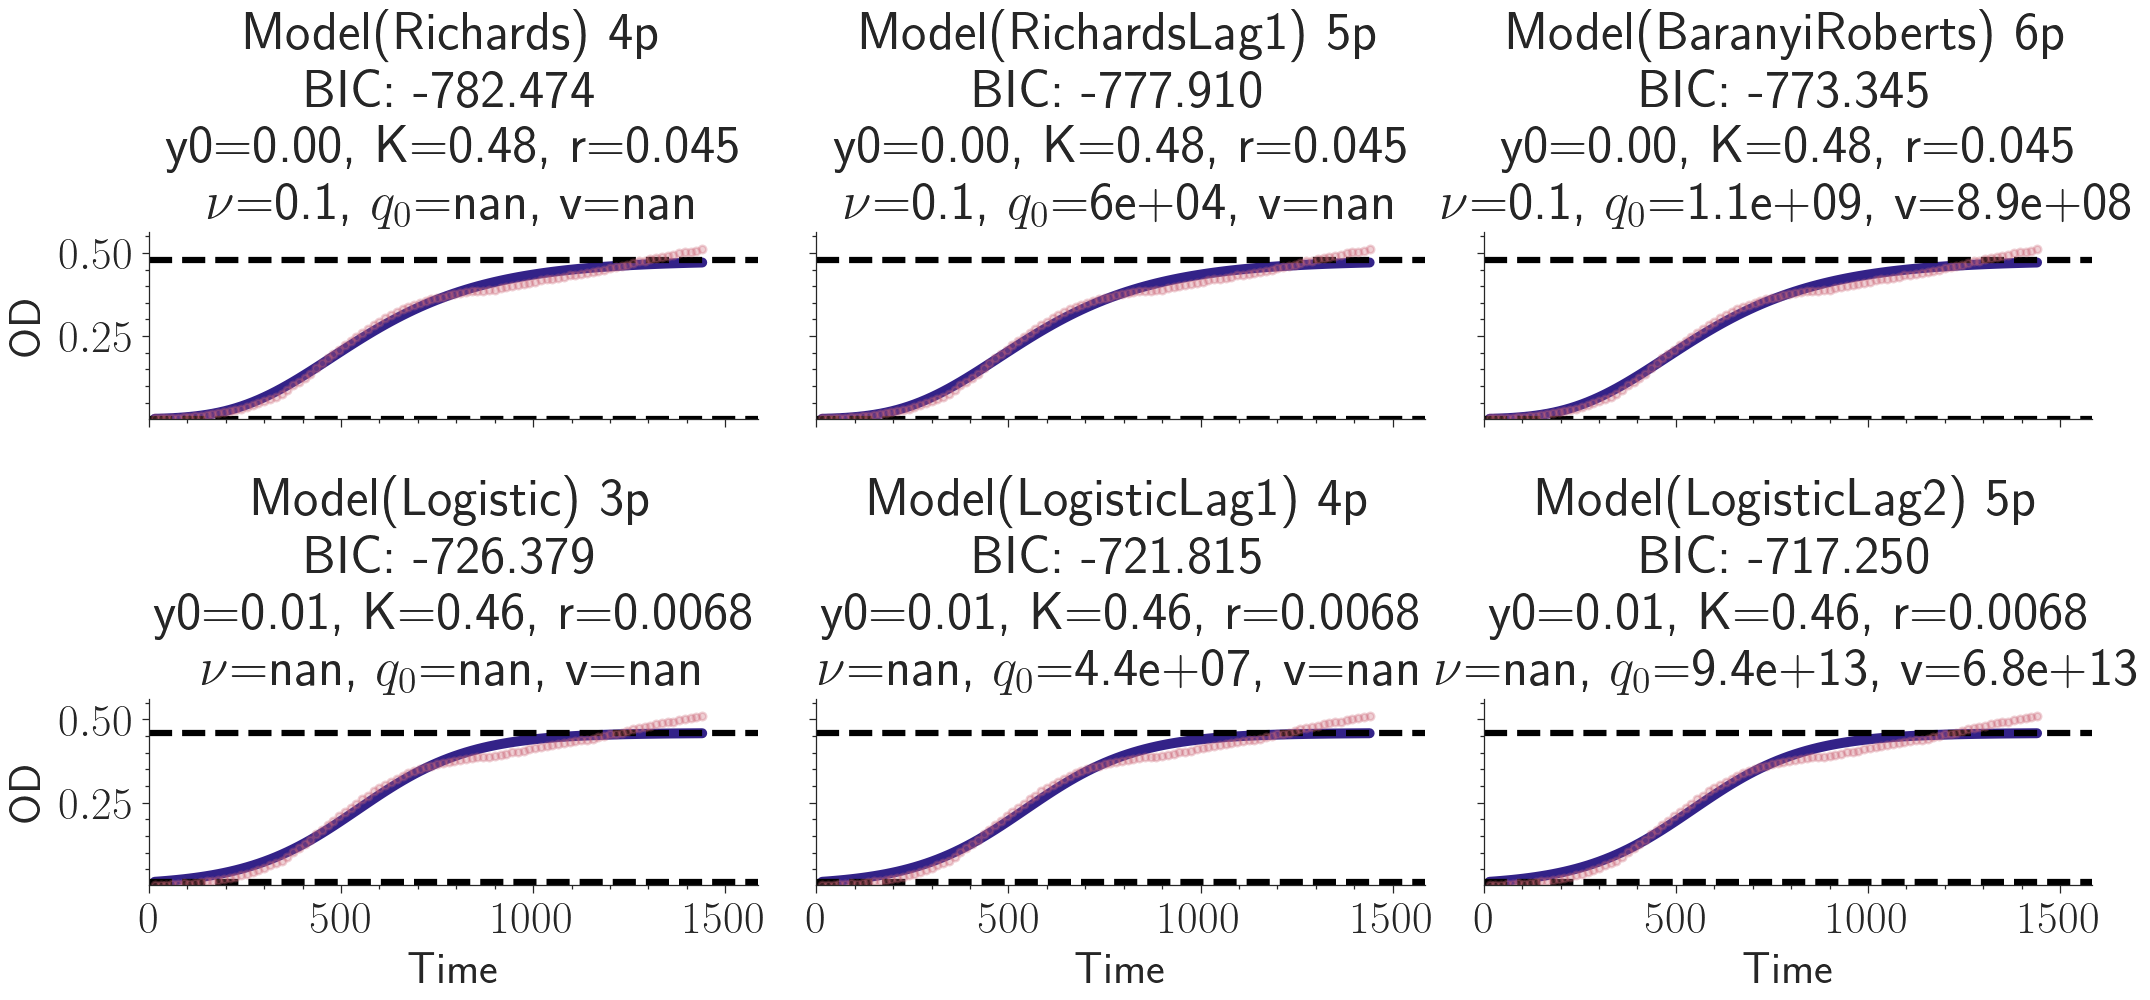

In [77]:
growth_data = media_avg['RPMI'][['Time', '14']]
res, fig, ax = curveball.models.fit_model(growth_data.rename({'14':'OD'},axis=1),PLOT=True,PRINT=False)
determine_td(res[3])